# Notebook to read a dataset and do basic field statistics and distributions

This is a nice notebook for your first interaction with a new data set. You can run it once, then start making modifications for your particular data set.

After you get your first look at the data with this notebook you may decide to switch some field types between how they are automatically selected as either numeric or categorical. Use the lists switch_n2c and switch_c2n for this, then run it again to get updated statistics tables. You can put the datetime fields as numeric for now but later you might decide they'd be better as categorical.

It's fine to use the automated simple distribution plots over all the fields, but for a proper examination field by field and for a Data Quality Report you should make individual plots for each field with appropriate ranges and lin/log y scale choices for each field.

If your problem is a supervised predictive model then there's a cell that will plot field populations along with the overall average of the dependent variable field, if you can identify an approprite y at this point. This can give you a feel for which fields will likely be predictive.

There's also two placeholder cells at the bottom that will plot a distribution for either a categorical or numeric field. You can use these cells and copy them as needed for fields where you want to make the plot more appropriate for a DQR, primarily adjusting the x range and the y scale, log or linear.

In [59]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
start_time = dt.datetime.now()
print('LOAD DURATION: ', dt.datetime.now() - start_time)

LOAD DURATION:  0:00:00.000026


In [60]:
%%time
data = pd.read_csv('card transactions_2025.csv')
# data = pd.read_json('transactions.txt', lines=True)
data.head()

CPU times: user 45.8 ms, sys: 13 ms, total: 58.8 ms
Wall time: 61.1 ms


,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [61]:
print('data.shape=',data.shape)
data.dropna(how='all', axis=1, inplace=True) # drop any empty columns
print('data.shape=',data.shape)
print(data.info())

data.shape= (98393, 10)
data.shape= (98393, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98393 entries, 0 to 98392
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             98393 non-null  int64  
 1   Cardnum            98393 non-null  int64  
 2   Date               98393 non-null  object 
 3   Merchnum           94970 non-null  object 
 4   Merch description  98393 non-null  object 
 5   Merch state        97181 non-null  object 
 6   Merch zip          93664 non-null  float64
 7   Transtype          98393 non-null  object 
 8   Amount             98393 non-null  float64
 9   Fraud              98393 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 7.5+ MB
None


In [62]:
data.tail().transpose()

,98388,98389,98390,98391,98392
Recnum,98389,98390,98391,98392,98393
Cardnum,5142276053,5142225701,5142226486,5142244619,5142243247
Date,12/31/10,12/31/10,12/31/10,12/31/10,12/31/10
Merchnum,3500000006160,8090710030950,4503057341100,8834000695412,9108347680006
Merch description,BEST BUY 00001610,MARKUS OFFICE SUPPLIES,"TECH PAC, INC",BUY.COM,STAPLES NATIONAL #471
Merch state,KY,OH,OH,CA,NJ
Merch zip,41042.0,45248.0,45150.0,92656.0,7606.0
Transtype,P,P,P,P,P
Amount,84.79,118.75,363.56,2202.03,554.64
Fraud,0,0,0,0,0


In [63]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

print(mem_usage(data))

34.18 MB


In [64]:
# add a dummy categorical column for the case the fields all look numeric. This helps build the stats tables.
data['dummy'] = 'temp'

In [65]:
df_stats = pd.DataFrame(data.count(),columns=['count'])
df_stats['isna'] = data.isna().sum()
df_stats['% pop'] = 1 - data.isna().sum()/len(data)
df_stats

,count,isna,% pop
Recnum,98393,0,1.000000
Cardnum,98393,0,1.000000
Date,98393,0,1.000000
Merchnum,94970,3423,0.965211
Merch description,98393,0,1.000000
Merch state,97181,1212,0.987682
Merch zip,93664,4729,0.951938
Transtype,98393,0,1.000000
Amount,98393,0,1.000000
Fraud,98393,0,1.000000


In [66]:
data.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Recnum,98393.0,NaN,NaN,NaN,49197.0,28403.756855,1.0,24599.0,49197.0,73795.0,98393.0
Cardnum,98393.0,NaN,NaN,NaN,5142201833.277286,55610.415971,5142110002.0,5142152067.0,5142195612.0,5142245738.0,5142847398.0
Date,98393,365,2/28/10,691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Merchnum,94970,13091,930090121224,9485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Merch description,98393,13126,GSA-FSS-ADV,1715,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Merch state,97181,227,TN,12243,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Merch zip,93664.0,NaN,NaN,NaN,44676.458394,28365.178554,1.0,20855.0,38118.0,63103.0,99999.0
Transtype,98393,4,P,98038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,98393.0,NaN,NaN,NaN,424.290926,9922.487427,0.01,33.37,137.03,425.0,3102045.53
Fraud,98393.0,NaN,NaN,NaN,0.025327,0.157117,0.0,0.0,0.0,0.0,1.0


### Make best guess to automatically set numerics or categoricals

In [67]:
# after you run it you may want to switch some field to the other type and rerun
df = data.describe(include='all')
frac_unique = df.loc['unique']/ df.loc['count']
s1 = frac_unique.isna()
s2 = np.where(s1)[0]
s3 = np.where(s1 == False)[0]
numerics = data.columns[s2].tolist()
categoricals = data.columns[s3].tolist()

for col in data.columns:
    numunique = data[col].nunique()
    if numunique == len(data) or numunique <=6: # you can adjust this upper limit for your data set
            if col in numerics:
                numerics.remove(col)
                categoricals.extend([col])

# manually switch some if desired            
switch_n2c = ['Merch zip','Cardnum']
switch_c2n = []
numerics = [s for s in numerics if s not in switch_n2c]
categoricals = [s for s in categoricals if s not in switch_c2n]
numerics.extend(switch_c2n)
categoricals.extend(switch_n2c)
categoricals.remove('dummy')
data = data.drop(columns='dummy')
            
print('numerics:',numerics)     
print('\ncategoricals:',categoricals)     

numerics: ['Amount']

categoricals: ['Date', 'Merchnum', 'Merch description', 'Merch state', 'Transtype', 'Recnum', 'Fraud', 'Merch zip', 'Cardnum']


In [68]:
def count_zeros(data):
    count = 0
    for i in data:
        if i == 0:
            count += 1
    return count

In [69]:
%%time
statistics_of_data1 = []
for col in numerics:
    num_zeros = count_zeros(data[col])
    percent_zeros = num_zeros / data.shape[0] * 100
    statistics_of_data1.append((col,
                             'numeric',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100:.2f}%',
#                              f'{percent_zeros:.2f}%',  # convert to percentage with 2 decimal places
                             count_zeros(data[col]),
                             round(data[col].min(), 2),
                             round(data[col].max(), 2),
                             data[col].mean(),
                             round(np.std(data[col]), 2),
                             data[col].mode()[0]
                             ))

stats_dfnum = pd.DataFrame(statistics_of_data1, columns = ['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros', 'Min', 'Max', 'Mean', 'Standard Deviation', 'Most Common'])
stats_dfnum.to_excel('numerics table.xlsx',index=False)
stats_dfnum

CPU times: user 15.3 ms, sys: 1.67 ms, total: 17 ms
Wall time: 16.4 ms


,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,Min,Max,Mean,Standard Deviation,Most Common
0,Amount,numeric,98393,100.00%,0,0.01,3102045.53,424.290926,9922.44,3.62


In [70]:
%%time
statistics_of_data = []
for col in categoricals:
    statistics_of_data.append((col,
                             'categorical',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100:.2f}%',
                             count_zeros(data[col]),
                             data[col].nunique(),
                             data[col].mode()[0]
                            
                             ))
stats_dfcat = pd.DataFrame(statistics_of_data, columns = ['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros','# Unique Values', 'Most Common',])
stats_dfcat.to_excel('categoricals table.xlsx',index=False)
stats_dfcat

CPU times: user 83.5 ms, sys: 2.64 ms, total: 86.1 ms
Wall time: 86.2 ms


,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,# Unique Values,Most Common
0,Date,categorical,98393,100.00%,0,365,2/28/10
1,Merchnum,categorical,94970,96.52%,0,13091,930090121224
2,Merch description,categorical,98393,100.00%,0,13126,GSA-FSS-ADV
3,Merch state,categorical,97181,98.77%,0,227,TN
4,Transtype,categorical,98393,100.00%,0,4,P
5,Recnum,categorical,98393,100.00%,0,98393,1
6,Fraud,categorical,98393,100.00%,95901,2,0
7,Merch zip,categorical,93664,95.19%,0,4567,38118.0
8,Cardnum,categorical,98393,100.00%,0,1645,5142148452


In [71]:
# Drop any column that has only a single value (it's not a useful column)
cats_drop = []
data.drop(cats_drop, axis=1, inplace=True)
categoricals = list(set(categoricals)  - set(cats_drop))

In [72]:
%%time
def get_dup_columns(m):
    '''
    This will check every column in data frame and verify if you have duplicated columns.
    The result will be a list of tuples showing what columns are duplicates. For example: (column A, column C)
    That means that column A is duplicated with column C
    '''
    headers_list = [x for x in m.columns]
    duplicate_col2 = []
    y = 0
    while y <= len(headers_list)-1:
        for x in range(1,len(headers_list)-1):
            if m[headers_list[y]].equals(m[headers_list[x]]) == False:        
                continue
            else:
                duplicate_col2.append((headers_list[y],headers_list[x]))
        headers_list.pop(0)  
    return duplicate_col2

# You can use this cell if you want to see if any of the columns are identical
duplicate_col = get_dup_columns(data)
duplicate_col

CPU times: user 783 µs, sys: 1.18 ms, total: 1.97 ms
Wall time: 1.45 ms


[]

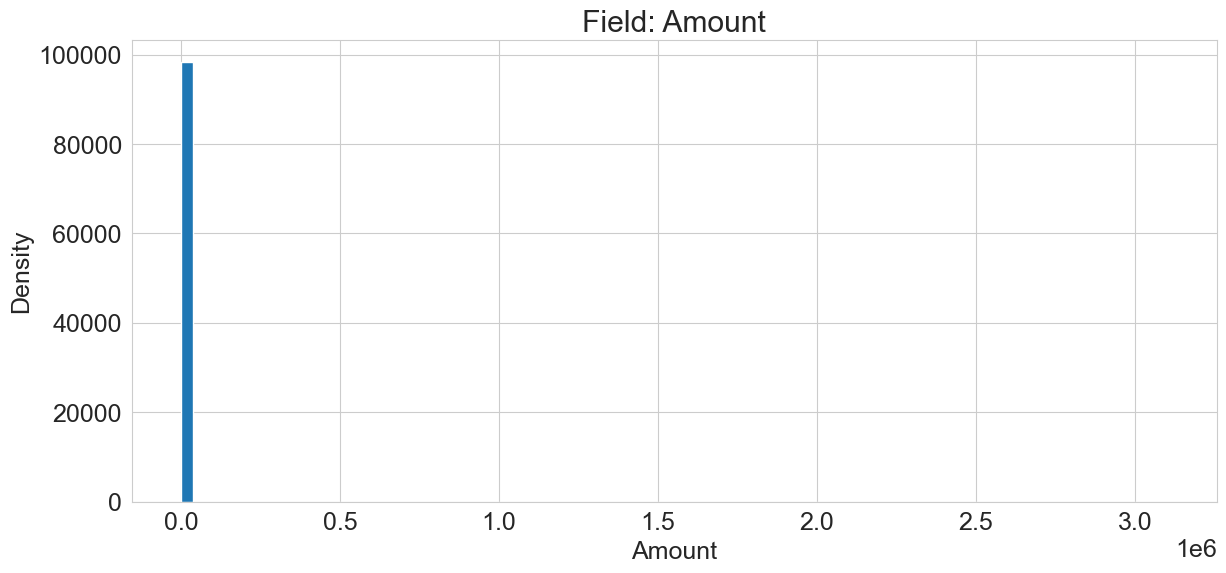

In [73]:
# plot numerics distributions if desired
plt.rcParams.update({'figure.figsize':(14,6)})
plt.rcParams.update({'font.size':18})
for col in numerics:
    plt.hist(data[col],bins=80)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title('Field: ' + col)
    plt.show()

In [107]:
# Re-import everything due to code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Reload the dataset
file_path = "card transactions_2025.csv"
df = pd.read_csv(file_path)

# Data slices
amount_data = df["Amount"].dropna()
normal = amount_data[amount_data <= 3000]
high_outliers = amount_data[(amount_data > 3000) & (amount_data <= 50000)]
mega_outliers = amount_data[amount_data > 50000]
max_val = mega_outliers.max()

# Formatter for commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')

# Set Seaborn style
sns.set_style("whitegrid")

# Create 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

# Panel (a) Normal
bin_width = 100
bins = np.arange(0, normal.max() + bin_width, bin_width)
sns.histplot(normal, bins=bins, edgecolor='black', ax=axes[0])

# sns.histplot(normal, bins=bins, edgecolor='black', ax=axes[0])

# sns.histplot(normal, bins=25, edgecolor='black', ax=axes[0])
axes[0].set_title("(a) Normal Transactions (≤ $3,000)", fontsize=20, fontweight='bold')
axes[0].set_xlabel("Amount", fontsize=18)
axes[0].set_ylabel("Frequency")
axes[0].xaxis.set_major_formatter(formatter)
# axes[0].annotate(
#     f"{len(normal)/len(amount_data):.2%} of transactions are ≤ $5,000",
#     xy=(2500, 1),
#     xytext=(2500, 5000),
#     fontsize=10,
#     color='red'
# )
axes[0].annotate(
    "99.34% of\ntransactions ≤ $3,000",
    xy=(2500, 1),
    xytext=(2500, 5000),
    fontsize=18,
    color='red'
)
# Panel (b) Outliers
# bars = sns.histplot(high_outliers, bins=30, edgecolor='black', ax=axes[1])
bars = sns.histplot(high_outliers, bins=30, edgecolor='black', ax=axes[1])
bars.set(ylim=(0, max([p.get_height() for p in bars.patches]) + 10))  # set directly on AxesSubplot

axes[1].set_title("(b) Outliers (\$3,000 \u2013 \$50,000)", fontsize=20, fontweight='bold')
axes[1].set_xlabel("Amount", fontsize=18)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].set_xlim(5000, 50000)
# max_height = max([p.get_height() for p in bars.patches])
# axes[1].set_ylim(0, max_height + 10)
max_height = max(p.get_height() for p in bars.patches)
bars.set(ylim=(0, max_height + 10))  # ✅ Seaborn-safe
axes[1].set_xlim(min(high_outliers), max(high_outliers))
axes[1].annotate(
    f"{len(high_outliers)/len(amount_data):.2%} of\ntransactions\nfall in this range",
    xy=(min(high_outliers), 5),
    xytext=(min(high_outliers) + 4000, 100),
    fontsize=18,
    color='red'
)





# Panel (c) Mega Outliers
bin_edges = np.histogram_bin_edges(mega_outliers, bins=5)
bars3 = sns.histplot(mega_outliers, bins=bin_edges, edgecolor='black', ax=axes[2])
axes[2].set_title("(c) Extreme Outliers (> $50,000)",fontsize=20, fontweight='bold')
axes[2].set_xlabel("Amount", fontsize=18)
axes[2].xaxis.set_major_formatter(formatter)
axes[2].set_xlim(max_val - 500000, max_val + 500000)
axes[2].set_ylim(0, 1.5)
axes[2].tick_params(axis='x', labelrotation=30)
axes[2].set_xticks(bin_edges)
axes[2].annotate(
    f'Only 1 Transaction > $50,000',
    xy=(max_val, 1),
    xytext=(max_val * 0.8, 1.3),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=18,
    color='red'
)

# Main title & layout
plt.suptitle("Credit Card Transaction Amounts (Normal, Outliers, Extreme)", fontsize=24, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
axes[1].set_ylim(0, max_height + 10)  # 🔁 Re-set it
axes[1].set_xlim(min(high_outliers), max(high_outliers))
axes[1].set_xticks(np.linspace(5000, 50000, num=6))  # or 6 or 8 if 10 is too dense
axes[1].set_ylabel("Frequency",)
axes[1].tick_params(axis='x', labelrotation=30)
axes[0].tick_params(axis='x', labelrotation=30)
axes[2].set_ylabel("Frequency")

# Save it
three_panel_sns_path = "Amount_Distribution_Three_Panel_Seaborn.png"
plt.savefig(three_panel_sns_path)
plt.close()

three_panel_sns_path


'Amount_Distribution_Three_Panel_Seaborn.png'

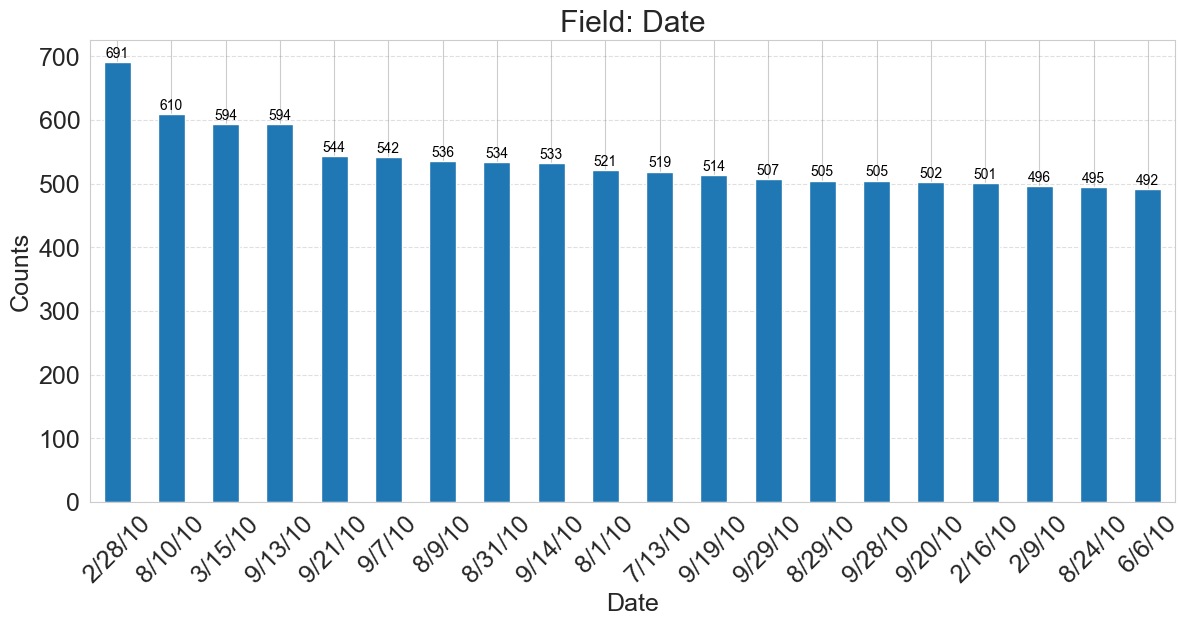

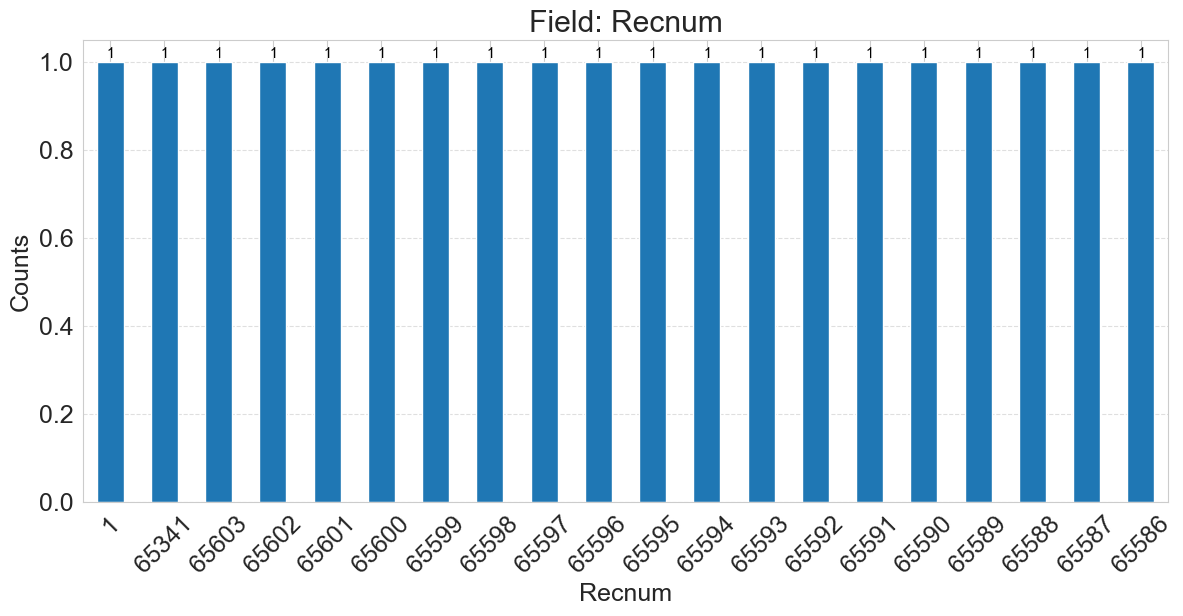

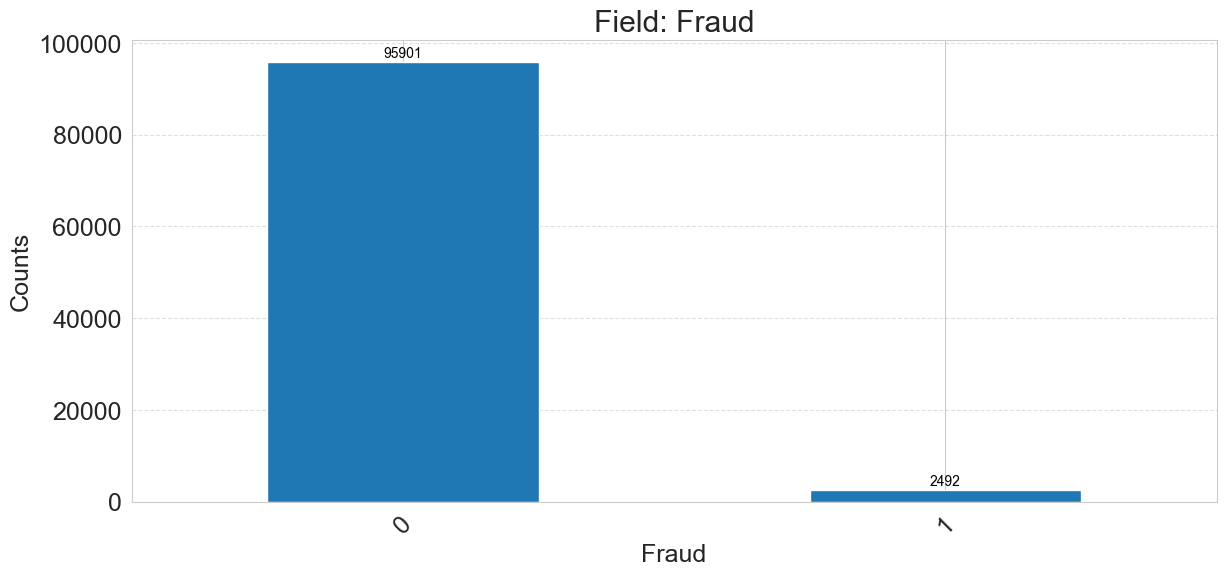

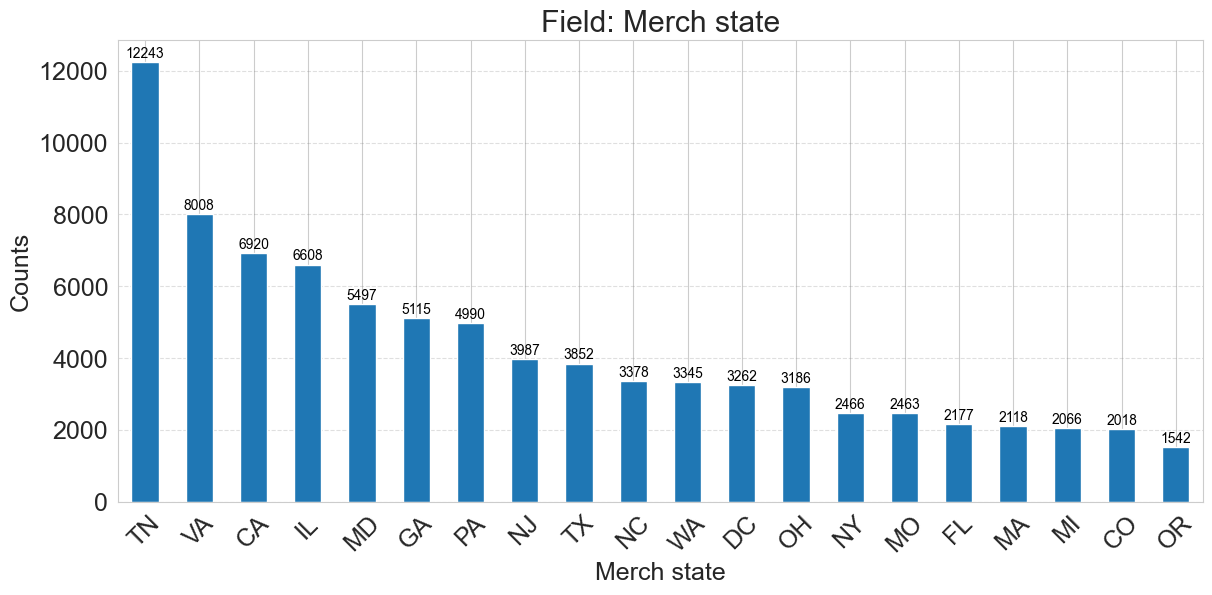

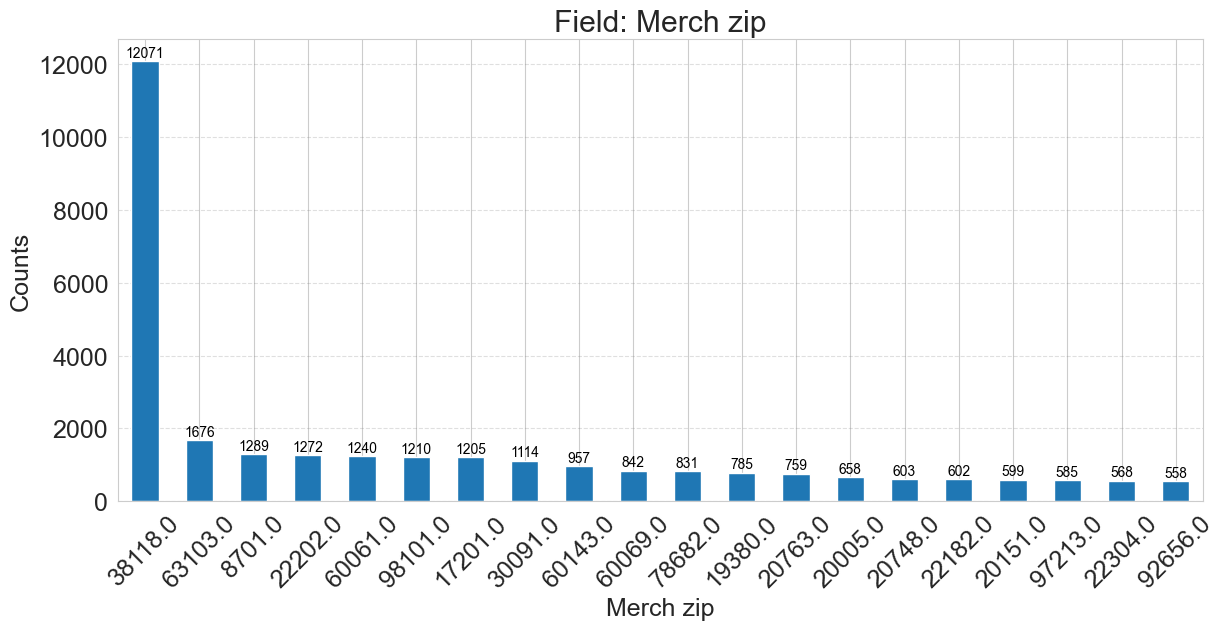

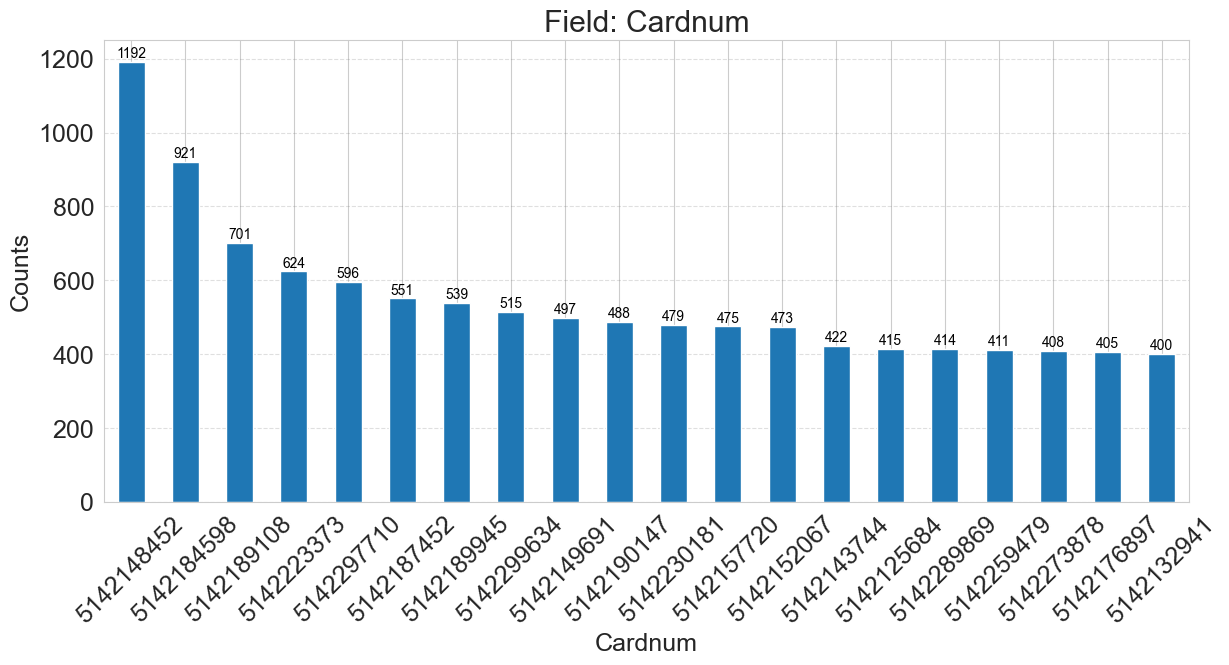

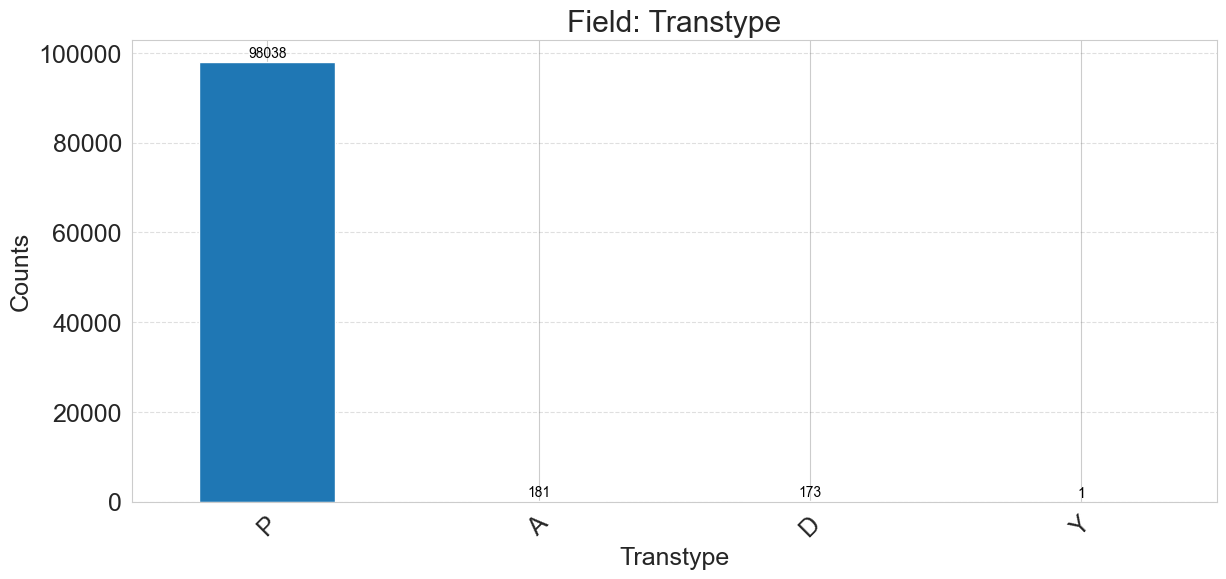

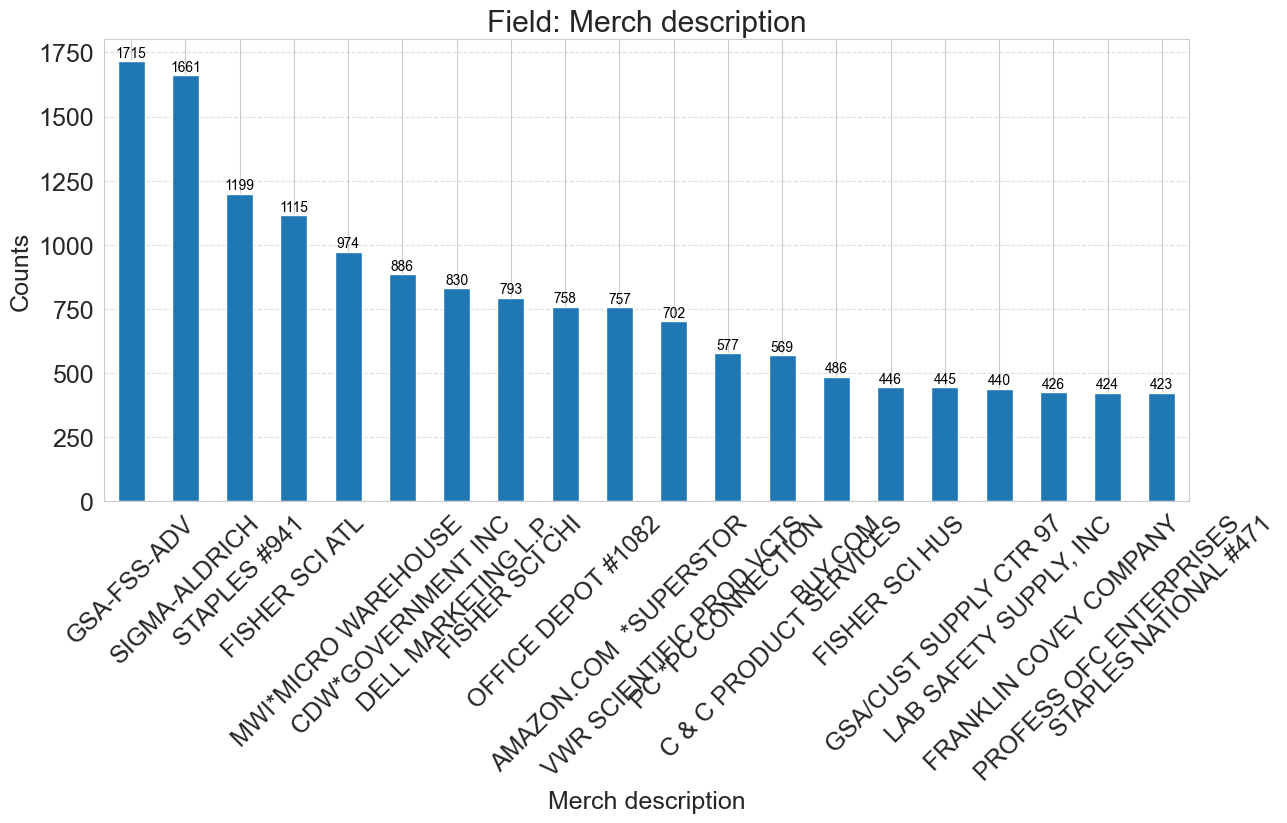

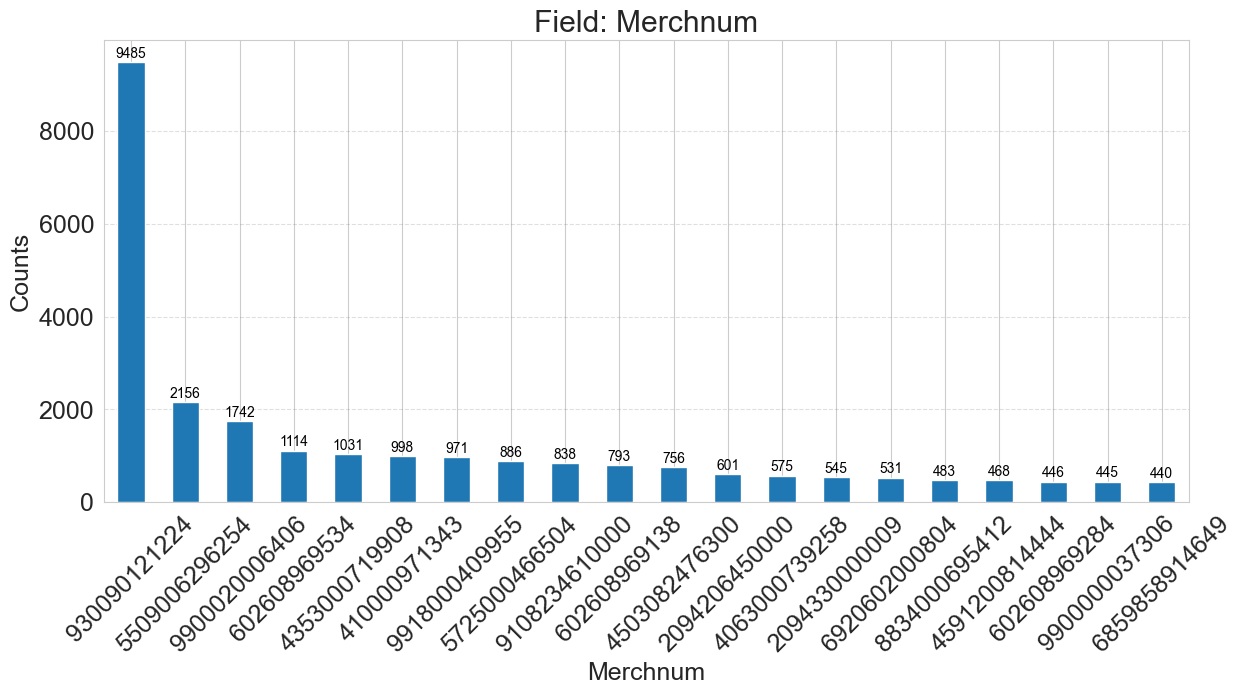

In [85]:
# plot categorical histograms if desired
for col in categoricals:
    counts = data[col].value_counts().head(20)
    ax = counts.plot(kind='bar')
    plt.xticks(rotation=45)
    for i, v in enumerate(counts):
        ax.text(i, v + counts.max()*.01, v, ha='center', color='black', fontsize=10)

    plt.title('Field: ' + col)
    plt.xlabel(col)
    plt.ylabel('Counts')
    ax.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=.25)
    plt.show()

/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/933815603.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Fraud', palette='Set2')
/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/933815603.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Not Fraud', 'Fraud'], fontsize=11)
/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/933815603.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x:,}' for x in ax.get_yticks()], fontsize=11)


Text(0.5, 1.0, 'Field: Fraud')

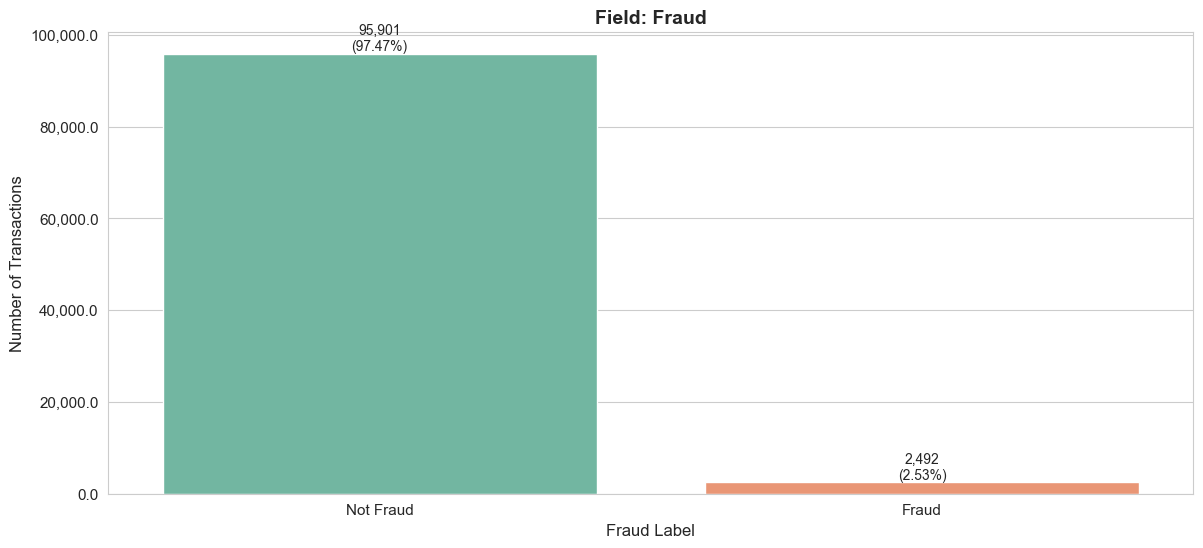

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(data=df, x='Fraud', palette='Set2')
total = len(df)

# Annotate count + %
for p in ax.patches:
    count = int(p.get_height())
    pct = count / total * 100
    ax.annotate(f"{count:,}\n({pct:.2f}%)", 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Clean axis
ax.set_xticklabels(['Not Fraud', 'Fraud'], fontsize=11)
ax.set_yticklabels([f'{x:,}' for x in ax.get_yticks()], fontsize=11)
ax.set_xlabel("Fraud Label", fontsize=12)
ax.set_ylabel("Number of Transactions", fontsize=12)
ax.set_title("Field: Fraud", fontsize=14, fontweight='bold')


In [138]:
# Re-run everything after code reset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "card transactions_2025.csv"
df = pd.read_csv(file_path)

# Prepare top 20 merchant states
top_states = df['Merch state'].value_counts().nlargest(20)

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=top_states.index, y=top_states.values, palette="Blues_d")

# Add count and percentage annotations
total = top_states.sum()
for p in ax.patches:
    count = int(p.get_height())
    percent = count / total * 100
    ax.annotate(f"{count:,}\n({percent:.1f}%)",
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=14)

# Title and labels
ax.set_title("Field: Merch state\n(Top 20 States by Transaction Count)", fontsize=18, fontweight="bold", pad=10)
ax.set_xlabel("Merchant State", fontsize=18)
ax.set_ylabel("Number of Transactions", fontsize=18)
ax.tick_params(axis='x', labelrotation=45, labelsize=14)
ax.tick_params(axis='y', labelsize=14)


# Tight layout and save
plt.tight_layout()

# Add a footnote with state full names
plt.figtext(0.5, -0.001,
            "State Code Reference: TN = Tennessee, VA = Virginia, CA = California, IL = Illinois, MD = Maryland, GA = Georgia,"
            " PA = Pennsylvania, NJ = New Jersey, TX = Texas, NC = North Carolina, WA = Washington, DC = District of Columbia, OH = Ohio, "
            "NY = New York, MO = Missouri, FL = Florida, MA = Massachusetts, MI = Michigan, CO = Colorado, OR = Oregon\n",
            wrap=True, ha='center', fontsize=12)
plt.subplots_adjust(bottom=0.25) 
output_path = "Merchant_State_Distribution_Cleaned.png"
plt.savefig(output_path)
plt.close()



output_path


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/16588925.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_states.index, y=top_states.values, palette="Blues_d")


'Merchant_State_Distribution_Cleaned.png'

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Transtype counts
transtype_counts = df['Transtype'].value_counts()
total = transtype_counts.sum()

# Plot
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='Transtype', order=transtype_counts.index, palette="Set2")

# Annotate counts + percentages
for p in ax.patches:
    # ax.annotate(f"{value:,}\n({pct:.2f}%)",
    #             (p.get_x() + p.get_width() / 2., value),
    #             ha='center', va='bottom', fontsize=10)
    value = int(p.get_height())
    pct = value / total * 100
    if pct < 0.01:
        label = f"{value:,}\n(<0.01%)"
    else:
        label = f"{value:,}\n({pct:.2f}%)"
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2., value),
                ha='center', va='bottom', fontsize=10)


# Format axes and title
ax.set_title("Field: Transtype", fontsize=14, fontweight="bold", pad=10)
ax.set_xlabel("Transtype", fontsize=12)
# ax.set_ylabel("Number of Transactions", fontsize=12)
plt.ylabel("Number of Transactions (log scale)", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Add footnote explaining codes
plt.figtext(0.5, -0.001,
            "Code Reference: P = Purchase, A = Adjustment, D = Debit, Y = Unknown\n",
            ha='center', fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
output_path = "Transtype_Distribution_Optimized.png"
plt.yscale('log')
plt.savefig(output_path)
plt.close()

output_path


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/3760606549.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Transtype', order=transtype_counts.index, palette="Set2")


'Transtype_Distribution_Optimized.png'

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 20 merchant descriptions
top_merchants = df['Merch description'].value_counts().nlargest(20)
total_merch = df['Merch description'].value_counts().sum()

# Create horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(y=top_merchants.index, x=top_merchants.values, palette="Blues_d")

# Annotate count + percentage
for p in ax.patches:
    count = int(p.get_width())
    pct = count / total_merch * 100
    ax.annotate(f"{count:,} ({pct:.1f}%)",
                (count + 50, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=9)

# Title and axis labels
ax.set_title("Field: Merch description\n(Top 20 Merchants by Transaction Count)", fontsize=14, fontweight='bold', pad=12)
ax.set_xlabel("Number of Transactions", fontsize=12)
ax.set_ylabel("Merchant", fontsize=12)
ax.tick_params(axis='y', labelsize=9)

# Layout and save
plt.tight_layout()
output_path = "Merch_Description_Distribution_Horizontal.png"
plt.savefig(output_path)
plt.close()

output_path


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/2878699249.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_merchants.index, x=top_merchants.values, palette="Blues_d")


'Merch_Description_Distribution_Horizontal.png'

overall dependent variable label rate is:  0.025327004969865743
98393 different values for Recnum
1645 different values for Cardnum


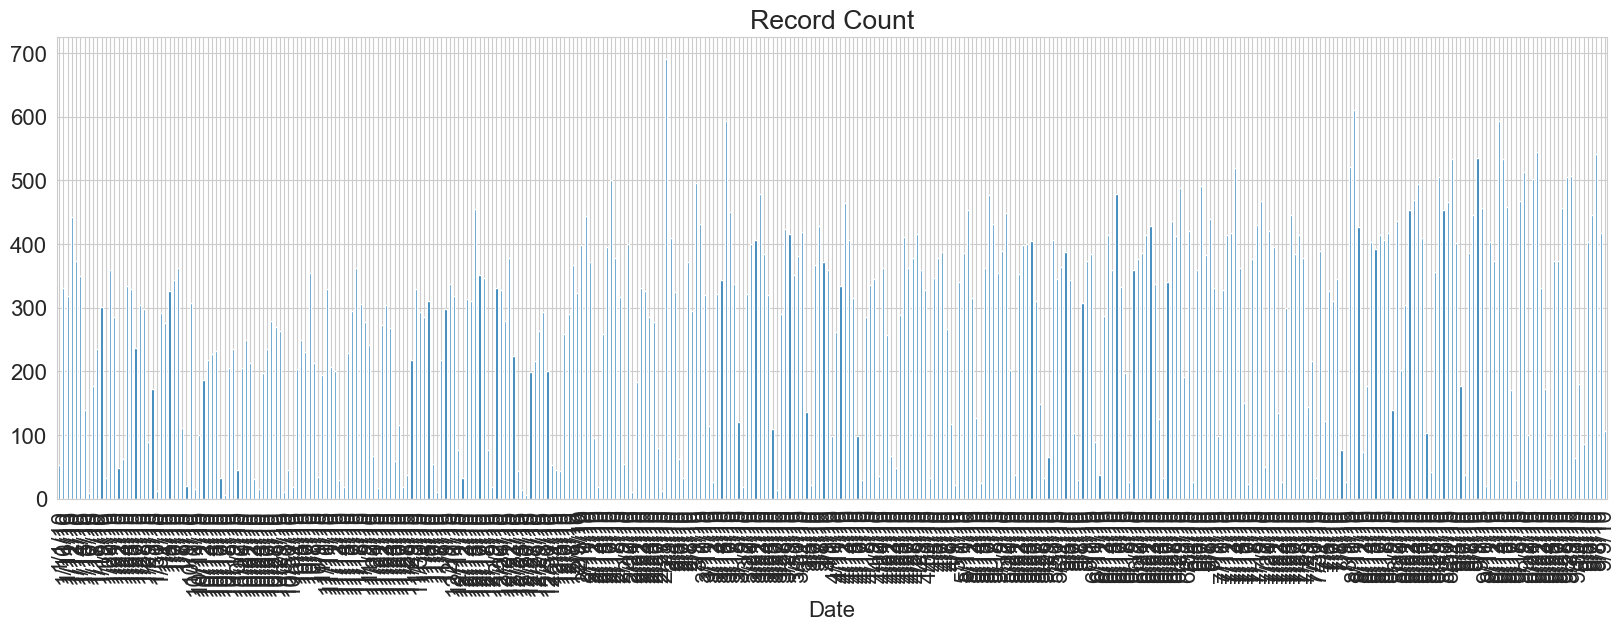

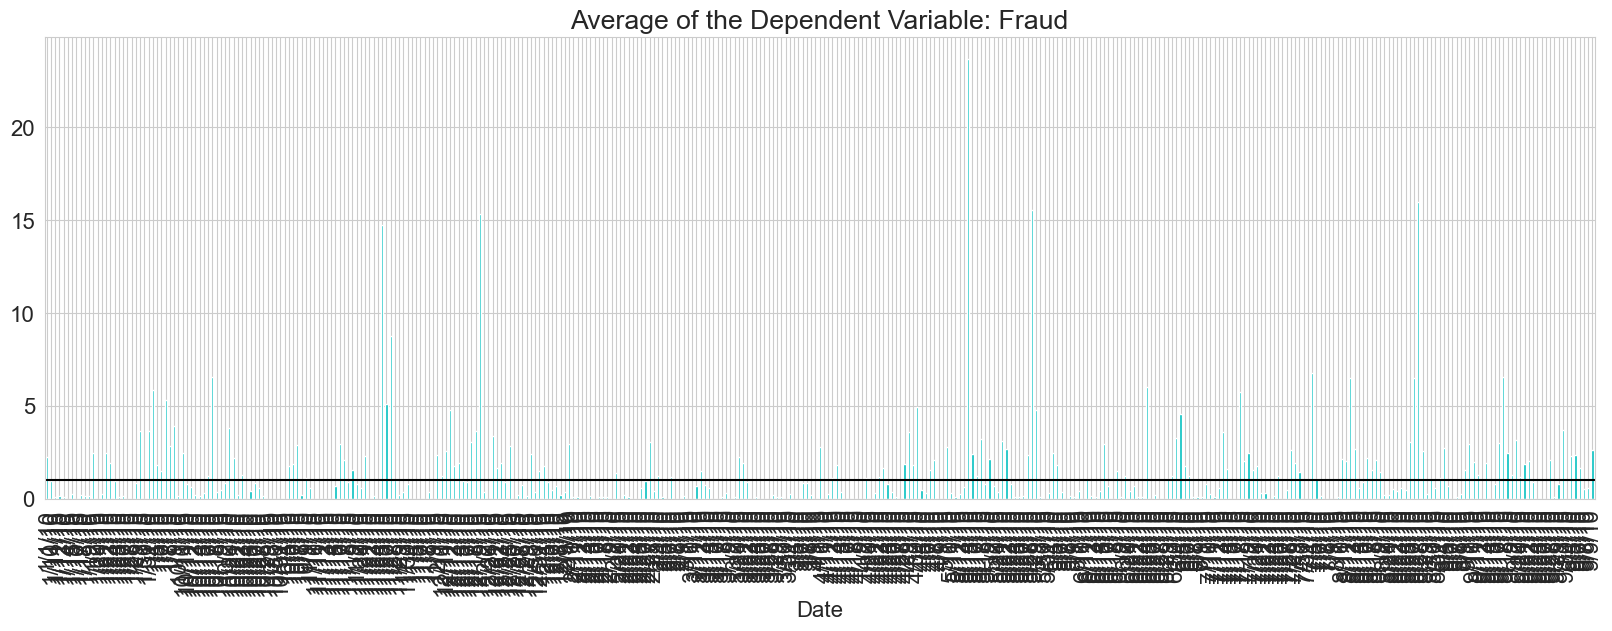

13091 different values for Merchnum
13126 different values for Merch description


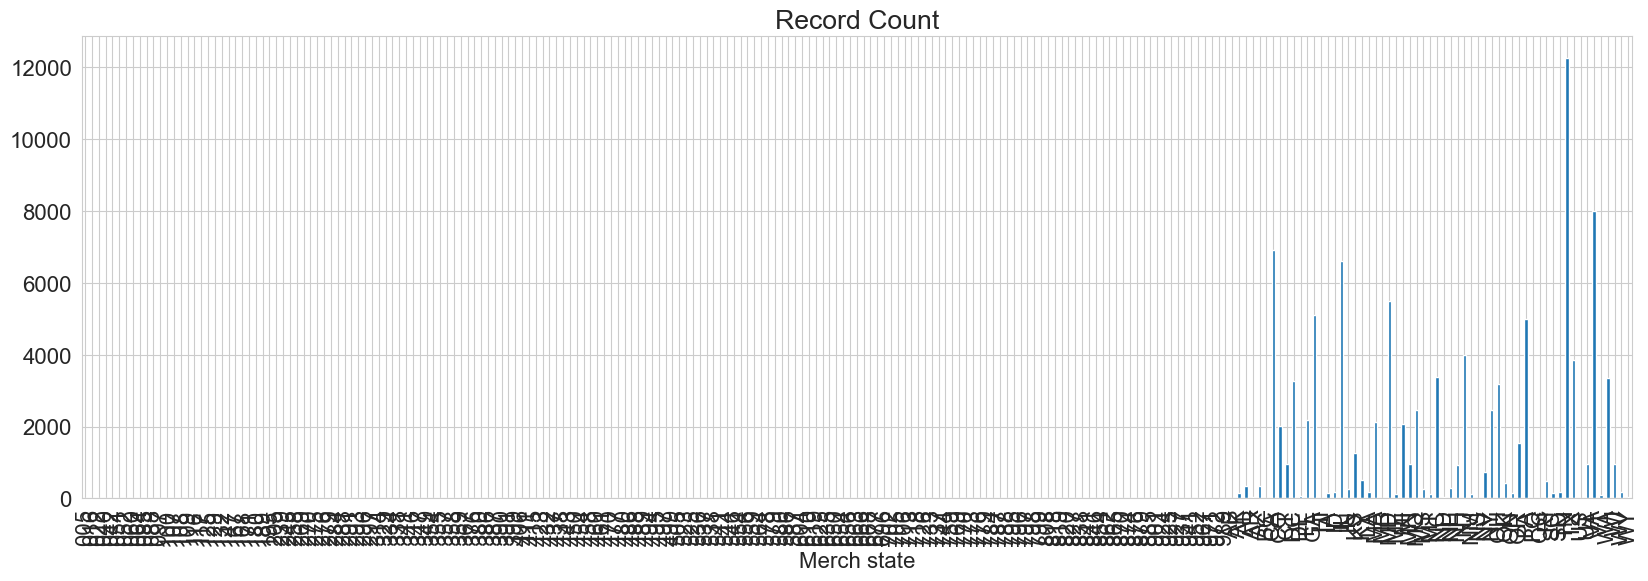

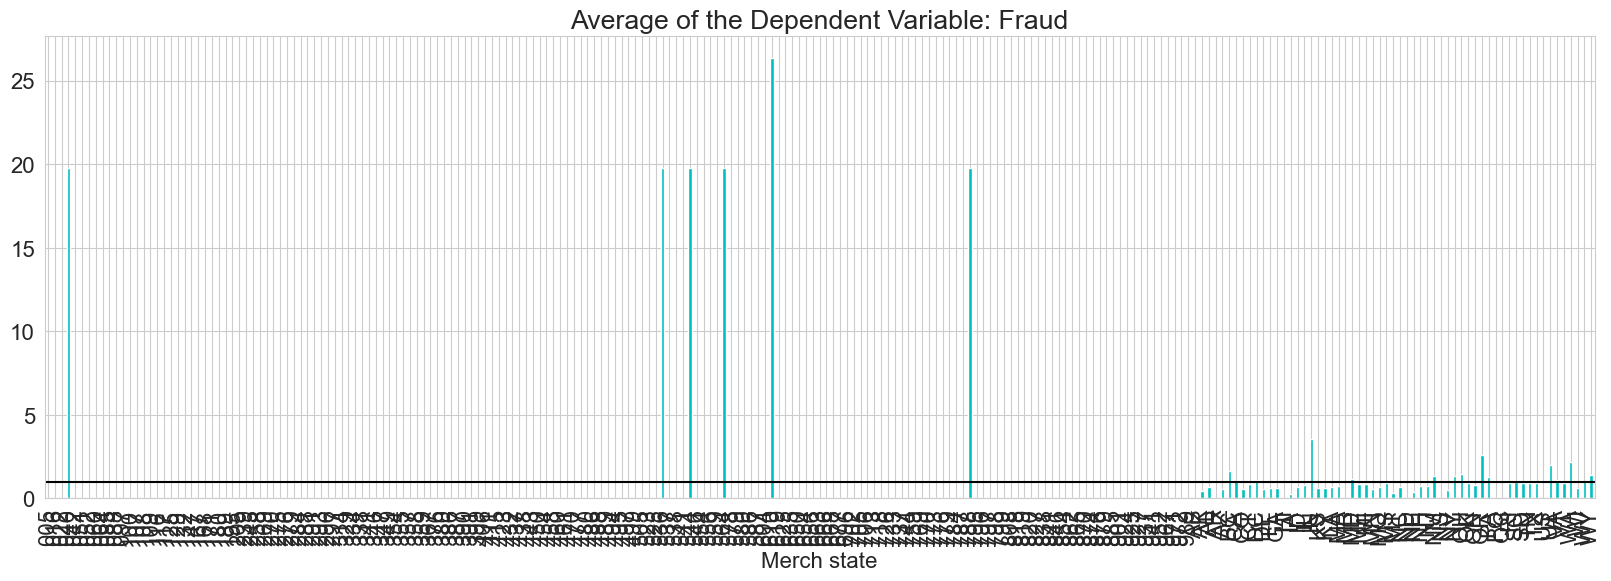

4567 different values for Merch zip


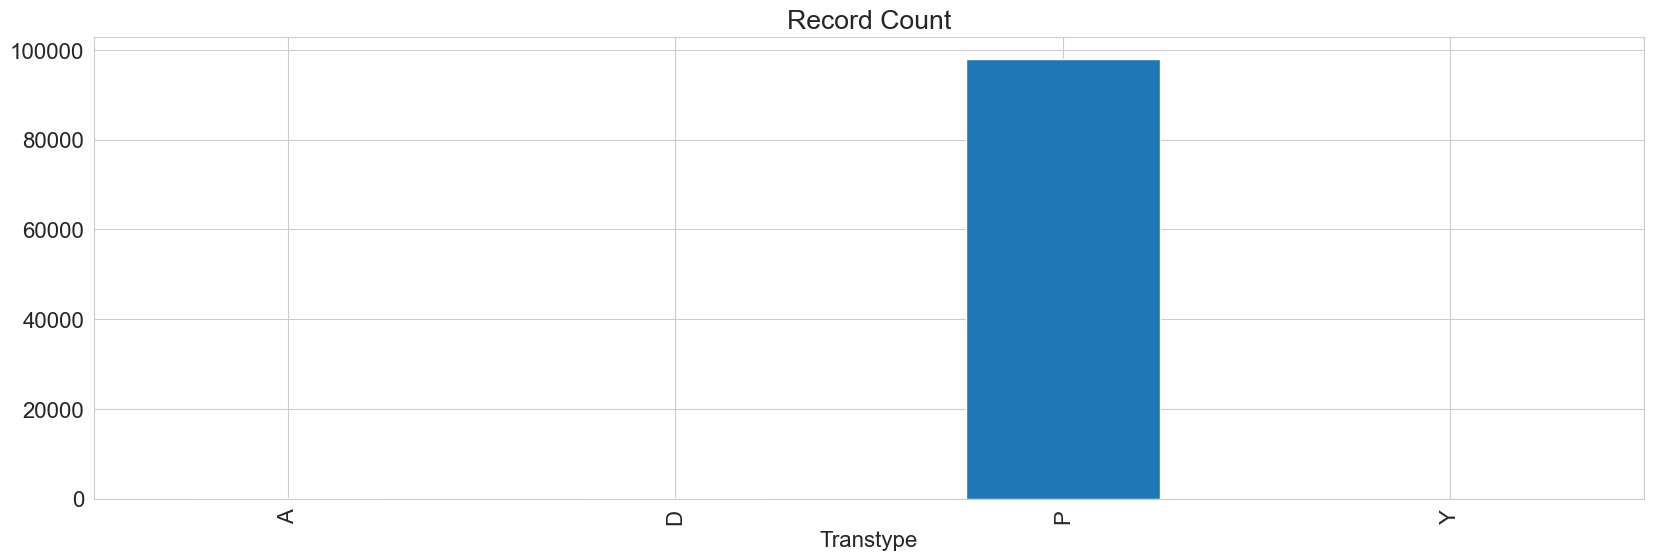

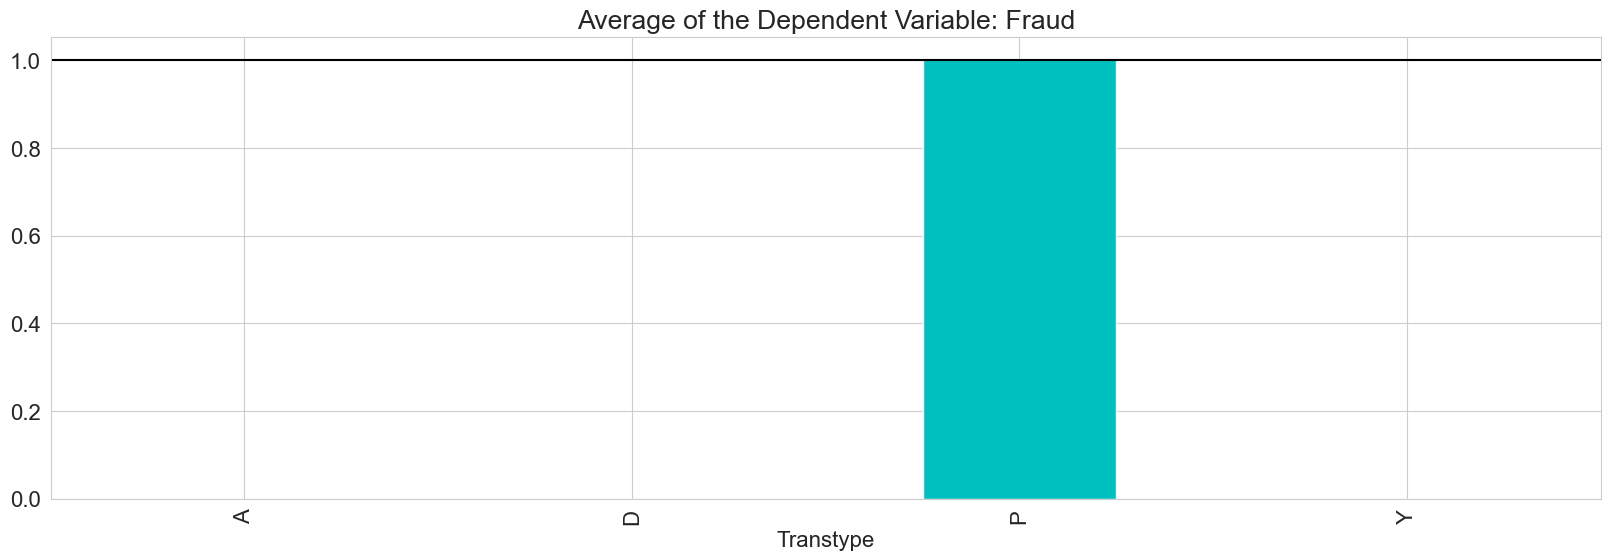

35565 different values for Amount


In [86]:
# This cell below is for supervised problem with a dependent variable y. 
# It looks at the univariate relationship between x and y.

dep_var = 'Fraud'

# sometimes need to convert the dependent variable to a number, particularly for a binary classification problem
# data[dep_var] = data[dep_var].map({False: 0, True: 1})
rate = data[dep_var].mean()

print('overall dependent variable label rate is: ', rate)
# Plot field distributions and compare with average of the dependent variable y (horizontal line)
plt.rcParams["figure.figsize"] = [20,6]
plt.rcParams.update({'font.size': 16})
plot_cols=data.columns.tolist()
# remove any fields you don't want to plot
# I put the range very high (370) so I could see a plot of 365 days. Usually you should set this to maybe 20 or so
plot_cols.remove(dep_var)
for col in plot_cols:
    num = data[col].nunique()
    if num > 370:
        print(num,"different values for",col)    
    else:
        plt.title('Record Count')
        plt.xlabel(col)
        data[col].value_counts().sort_index().plot(kind='bar')
        temp = data.groupby(col)[dep_var].mean() / rate
        plt.show()
        plt.xlabel(col)
        str = 'Average of the Dependent Variable: '+dep_var
        plt.title(str)
        plt.axhline(1,color='black')
        temp.plot(kind='bar',color='c')
        plt.show()

/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/305687191.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


Text(0.5, 1.0, 'Field:\xa0Date')

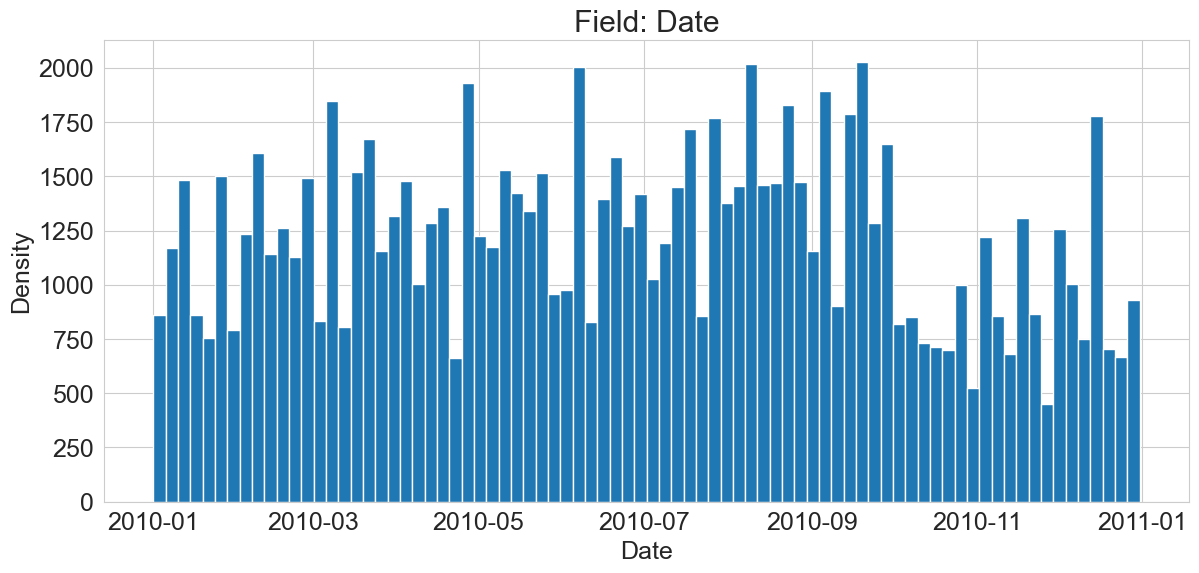

In [87]:
# Copy and use this cell as many times as needed to make customized plots for individual NUMERIC fields

plt.rcParams.update({'figure.figsize':(14,6)}) # make the plot size appropriate for the data
plt.rcParams.update({'font.size':18}) # make the font size appropriate for the plot
col = 'Date' # select a particular numeric field
data['Date'] = pd.to_datetime(data['Date'])
# set good x range values to make a plot that shows the important info as best as possible
# xlow = 20170101
# xhigh = 20171231
# plt.xlim(xlow,xhigh)
# let the bins span only the x range desired
# temp = data[data[col]<xhigh]
# temp = temp[temp[col]>xlow]
# plt.yscale('log') # use log y when the y range is so large that the bins to the right are really small
# plt.ylim(.1,1000000) # choose this to only show the decades needed
plt.hist(data[col], bins=80)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Field: ' + col)

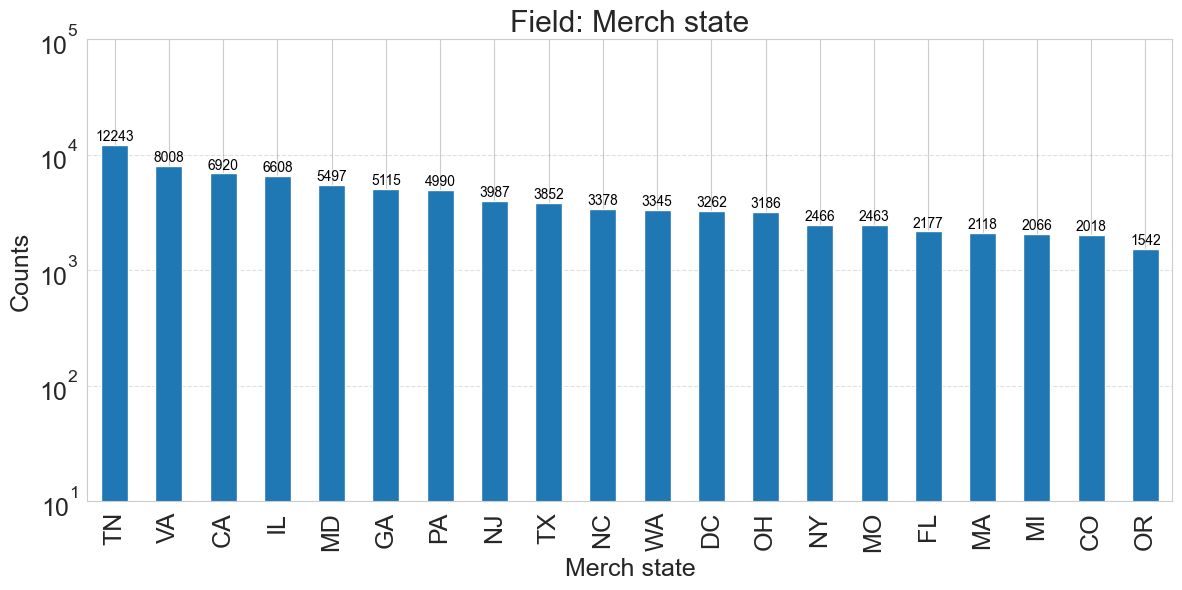

In [88]:
# Copy and use this cell as many times as needed to make customized plots for individual CATEGORICAL fields

plt.rcParams.update({'figure.figsize':(14,6)}) # make the plot size appropriate for the data
plt.rcParams.update({'font.size':18}) # make the font size appropriate for the plot
col='Merch state' # select a particular categorical field
counts = data[col].value_counts().head(20)
ax = counts.plot(kind='bar')
plt.xticks(rotation=90) # set this to what looks best
for i, v in enumerate(counts):
#     vdelta = v + counts.max()*.01 # this works better for lin y plots
    vdelta = v*1.1 # this works better for log y plots
    ax.text(i, vdelta, v, ha='center', color='black', fontsize=10)

plt.yscale('log') # use log y when the y range is so large that the bins to the right are really small
plt.ylim(10,100000) # choose this to only show the decades needed
plt.title('Field: ' + col)
plt.xlabel(col)
plt.ylabel('Counts')
ax.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=.25)
plt.show()

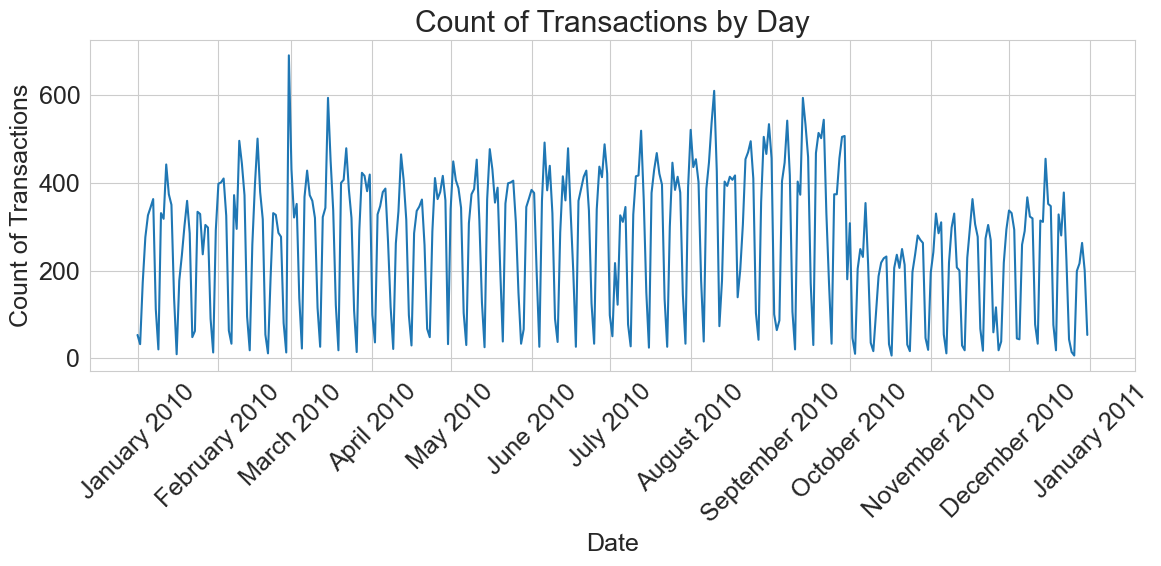

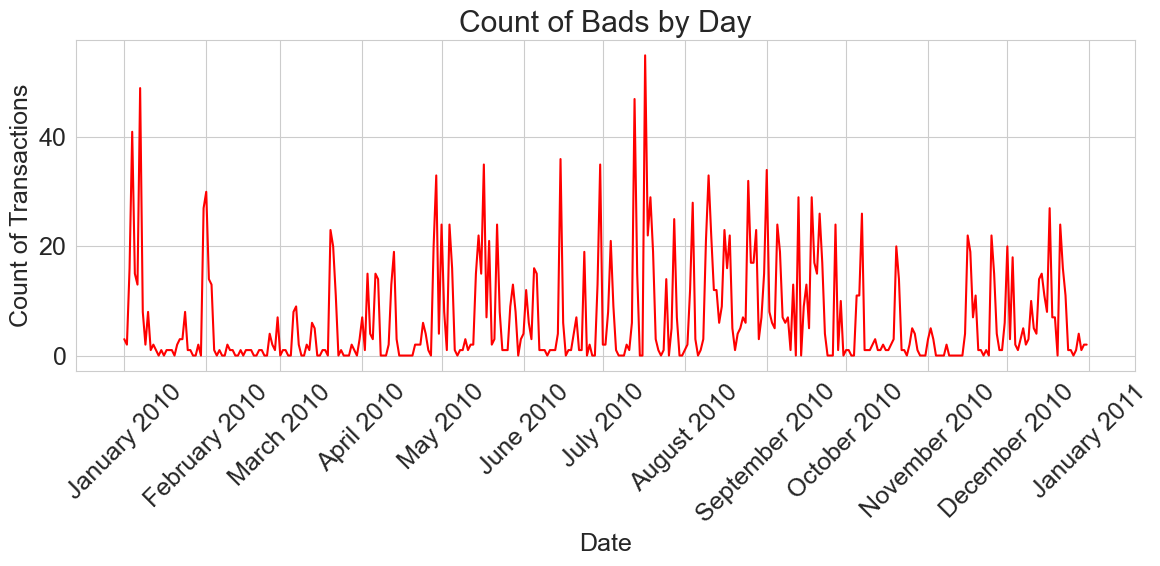

In [89]:
# If you want to make plots across time you can use this cell
# sort by time, set time as index so we can plot across time
# adjust the time scales as needed for your temp

import matplotlib.dates as mdates
time_field = 'Date' # after this, do whatever you need to to make this a datetime field
temp = data.copy()
# temp['appyear'] = (temp['date'] / 10000).astype('int')
# temp['appmonth'] = ((temp['date'] - temp['appyear'] * 10000) / 100).astype('int')
# temp['appday'] = temp['date'] - temp['appyear'] * 10000 - temp['appmonth'] * 100
# temp['date'] = pd.to_datetime(temp.appyear*10000+temp.appmonth*100+temp.appday,format='%Y%m%d')
temp[time_field] = pd.to_datetime(temp[time_field]) # you may have to adjust this for your particular time field
temp.sort_values(by=[time_field],inplace=True)
temp.set_index(time_field, inplace=True)
daily_counts = temp.resample('D').size()
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(daily_counts.index, daily_counts, marker='', linestyle='-')  # Plot as a line chart
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))  # Format ticks as full month name followed by year
plt.title('Count of Transactions by Day')
plt.xlabel('Date')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout

# If it's a binary classification problem, separate the types and plot
dep_var = 'Fraud' # do whatever you need to do to separate the two types
# temp[dep_var] = temp[dep_var].astype(str)
# goods = temp[temp[dep_var] == 'False']
# bads = temp[temp[dep_var] == 'True']
goods = temp[temp[dep_var] == 0]
bads = temp[temp[dep_var] == 1]
daily_counts_goods = goods.resample('D').size()
daily_counts_bads = bads.resample('D').size()
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(daily_counts_bads.index, daily_counts_bads, marker='', linestyle='-', color='r')  # Plot as a line chart
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))  # Format ticks as full month name followed by year
plt.title('Count of Bads by Day')
plt.xlabel('Date')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout

/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/1538062302.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


Text(0, 0.5, 'Frequency')

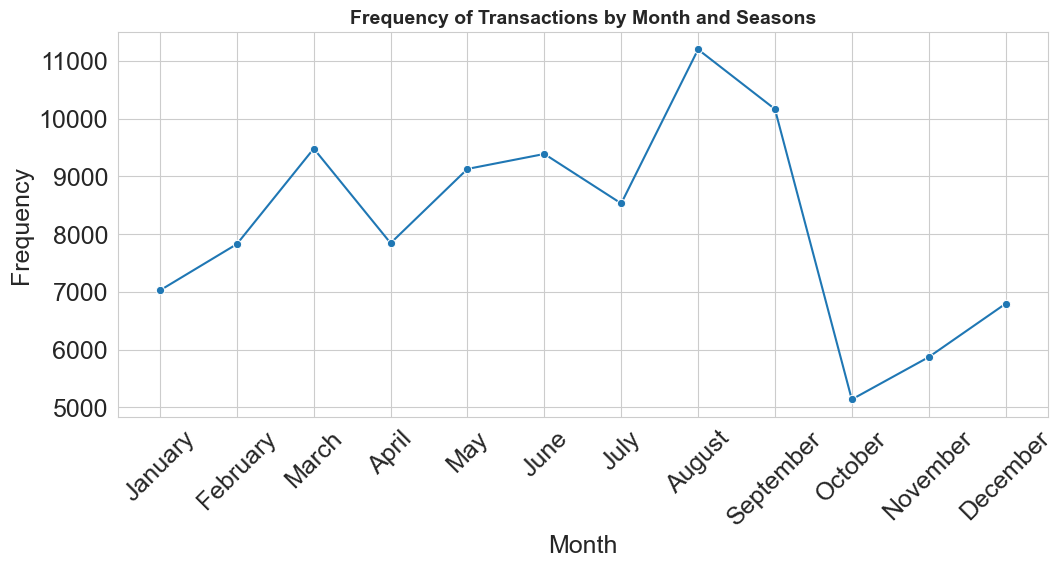

In [147]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month_name()
df['Month_num'] = df['Date'].dt.month

season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['Season'] = df['Date'].dt.month.map(season_map)

import seaborn as sns
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.groupby('Month_num')['Date'].count().rename('Frequency').reset_index(),
             x='Month_num', y='Frequency', marker='o')
plt.xticks(ticks=range(1, 13), labels=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
], rotation=45)
plt.title("Frequency of Transactions by Month and Seasons", fontsize=14, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Frequency")


In [159]:
# Re-run everything after code reset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "card transactions_2025.csv"
df = pd.read_csv(file_path)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract month and season
df['Month_num'] = df['Date'].dt.month
df['Month_name'] = df['Date'].dt.month_name()

season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['Season'] = df['Month_num'].map(season_map)

# Group by month and count transactions
monthly_counts = df.groupby('Month_num').size().reset_index(name='Frequency')
monthly_counts['Month_name'] = monthly_counts['Month_num'].map(lambda x: pd.Timestamp(f'2023-{x:02d}-01').strftime('%B'))

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x='Month_name', y='Frequency', marker='o')
plt.title("Frequency of Transactions by Month and Seasons", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add season annotations
plt.axvline(x=2.5, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=5.5, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=8.5, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=11.5, color='gray', linestyle='--', alpha=0.3)
plt.text(0.5, plt.ylim()[1]*0.95, 'Winter', ha='center', fontsize=10)
plt.text(3.5, plt.ylim()[1]*0.95, 'Spring', ha='center', fontsize=10)
plt.text(6.5, plt.ylim()[1]*0.95, 'Summer', ha='center', fontsize=10)
plt.text(9.5, plt.ylim()[1]*0.95, 'Fall', ha='center', fontsize=10)
plt.text(11.5, plt.ylim()[1]*0.95, 'Winter', ha='center', fontsize=10)

plt.tight_layout()
output_path = "Monthly_Seasonal_Transaction_Frequency.png"
plt.savefig(output_path)
plt.close()

output_path


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/3253067717.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'Monthly_Seasonal_Transaction_Frequency.png'

In [ ]:
# Recreate the enhanced seasonal plot with shaded regions and annotations

import matplotlib.pyplot as plt
import seaborn as sns

# Group by month and count transactions
monthly_counts = df.groupby('Month_num').size().reset_index(name='Frequency')
monthly_counts['Month_name'] = monthly_counts['Month_num'].map(lambda x: pd.Timestamp(f'2023-{x:02d}-01').strftime('%B'))

# Month order for consistent plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_counts['Month_name'] = pd.Categorical(monthly_counts['Month_name'], categories=month_order, ordered=True)
monthly_counts = monthly_counts.sort_values('Month_name')

# Plot
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=monthly_counts, x='Month_name', y='Frequency', marker='o', linewidth=2)

# Title and labels
ax.set_title("Frequency of Transactions by Month and Seasons", fontsize=14, fontweight='bold')
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add shaded seasonal regions
ax.axvspan(-0.5, 2.5, color='lightblue', alpha=0.2, label='Winter')
ax.axvspan(2.5, 5.5, color='lightgreen', alpha=0.2, label='Spring')
ax.axvspan(5.5, 8.5, color='navajowhite', alpha=0.2, label='Summer')
ax.axvspan(8.5, 11.5, color='lightsalmon', alpha=0.2, label='Fall')

# Annotate peak month
peak_row = monthly_counts.loc[monthly_counts['Frequency'].idxmax()]
ax.annotate("Peak month",
            xy=(peak_row['Month_name'], peak_row['Frequency']),
            xytext=(peak_row['Month_name'], peak_row['Frequency'] - 1000),
            ha='center',
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=10,
            color='red')

# Legend for seasons
handles, labels = ax.get_legend_handles_labels()
season_labels = dict.fromkeys(['Winter', 'Spring', 'Summer', 'Fall'])
plt.legend(season_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, frameon=False)

plt.tight_layout()
output_path = "Monthly_Seasonal_Transaction_Frequency_Enhanced.png"
plt.savefig(output_path)
plt.close()

output_path


'Monthly_Seasonal_Transaction_Frequency_Enhanced.png'

In [165]:
# Regenerate the plot, safely ignoring legend removal if it doesn't exist

plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=monthly_counts, x='Month_name', y='Frequency', marker='o', linewidth=2)

# Title and labels
ax.set_title("Frequency of Transactions by Month and Seasons", fontsize=14, fontweight='bold')
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add seasonal background shading
ax.axvspan(-0.5, 2.5, color='lightblue', alpha=0.2)
ax.axvspan(2.5, 5.5, color='lightgreen', alpha=0.2)
ax.axvspan(5.5, 8.5, color='navajowhite', alpha=0.2)
ax.axvspan(8.5, 11.5, color='lightsalmon', alpha=0.2)

# Add seasonal labels
plt.text(0.5, plt.ylim()[1]*0.95, 'Winter', ha='center', fontsize=10)
plt.text(3.5, plt.ylim()[1]*0.95, 'Spring', ha='center', fontsize=10)
plt.text(6.5, plt.ylim()[1]*0.95, 'Summer', ha='center', fontsize=10)
plt.text(9.5, plt.ylim()[1]*0.95, 'Fall', ha='center', fontsize=10)

# Annotate peak month
peak_row = monthly_counts.loc[monthly_counts['Frequency'].idxmax()]
ax.annotate("Peak month",
            xy=(peak_row['Month_name'], peak_row['Frequency']),
            xytext=(peak_row['Month_name'], peak_row['Frequency'] - 1500),
            ha='center',
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=10,
            color='red')

# Save cleaned version
plt.tight_layout()
output_path = "Monthly_Seasonal_Transaction_Frequency_Cleaned.png"
plt.savefig(output_path)
plt.close()

output_path


'Monthly_Seasonal_Transaction_Frequency_Cleaned.png'

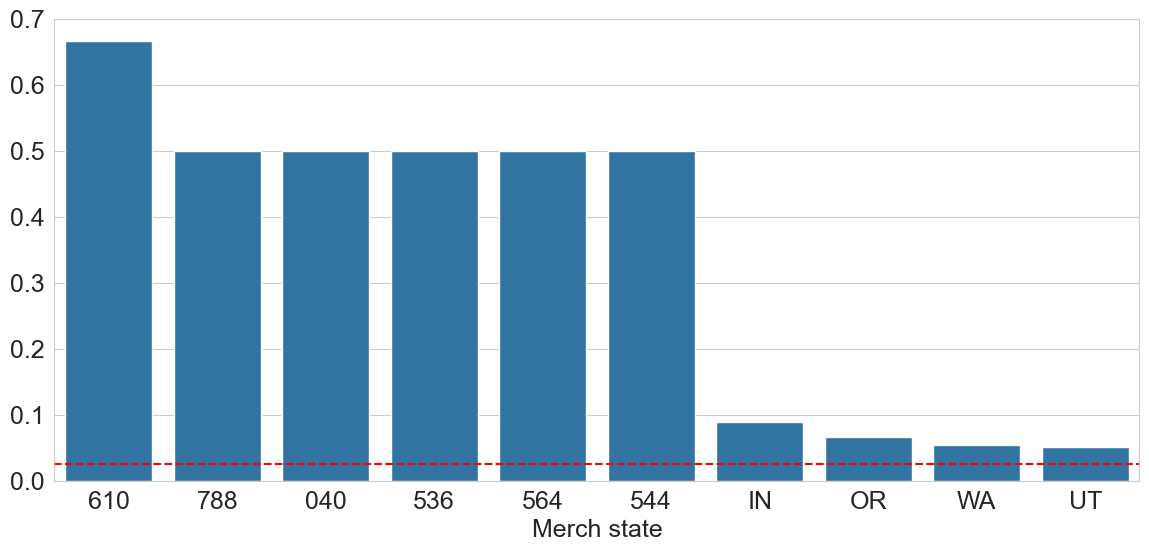

In [168]:
fraud_rate = df.groupby("Merch state")["Fraud"].mean().sort_values(ascending=False)
sns.barplot(x=fraud_rate.index[:10], y=fraud_rate.values[:10])
plt.axhline(df["Fraud"].mean(), color='red', linestyle='--', label="Average Fraud Rate")


<Axes: >

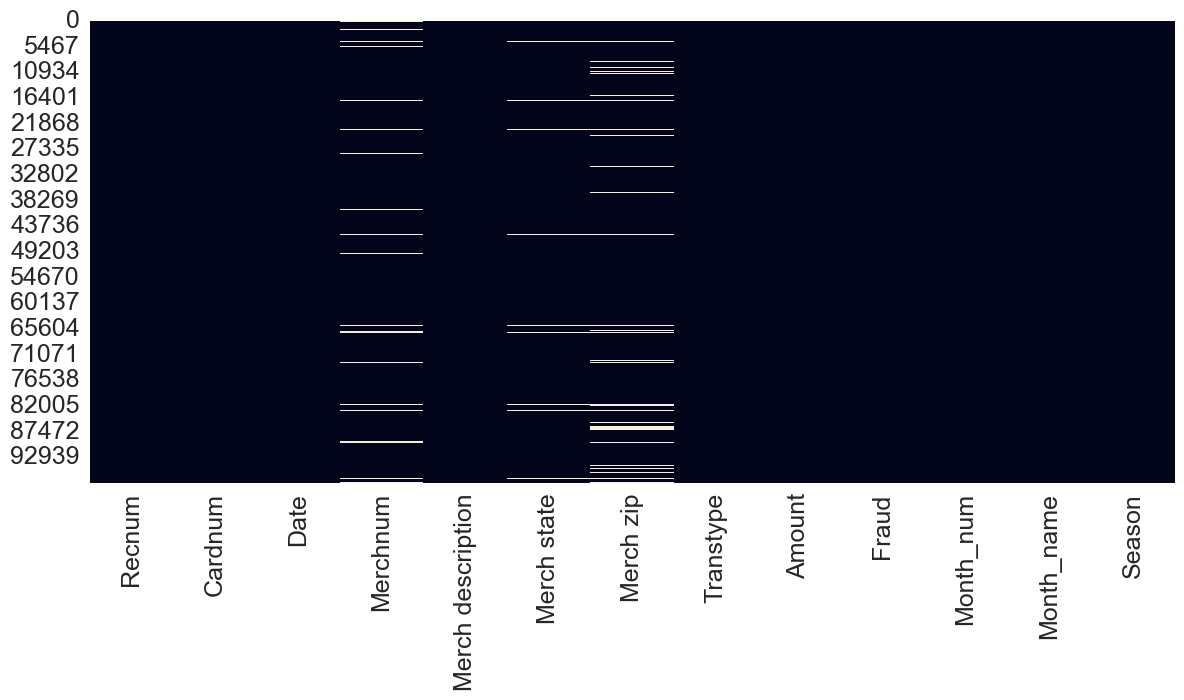

In [170]:
sns.heatmap(df.isnull(), cbar=False)


In [90]:
%pwd

'/Users/nujoumunus/SP25/Fraud_Analytics/HW1'

In [91]:
print('duration: ', dt.datetime.now() - start_time)

duration:  0:00:07.322316


In [172]:
df['Merch state'].value_counts().tail(10)

Merch state
559    1
879    1
399    1
759    1
022    1
656    1
495    1
376    1
458    1
116    1
Name: count, dtype: int64

In [187]:
weird_states = df[~df['Merch state'].str.match(r'^[A-Z]{2}$', na=False)]
display(weird_states['Merch state'].value_counts())

Merch state
696    3
610    3
788    2
901    2
536    2
      ..
022    1
656    1
495    1
376    1
116    1
Name: count, Length: 168, dtype: int64

Text(0.5, 0, 'Count')

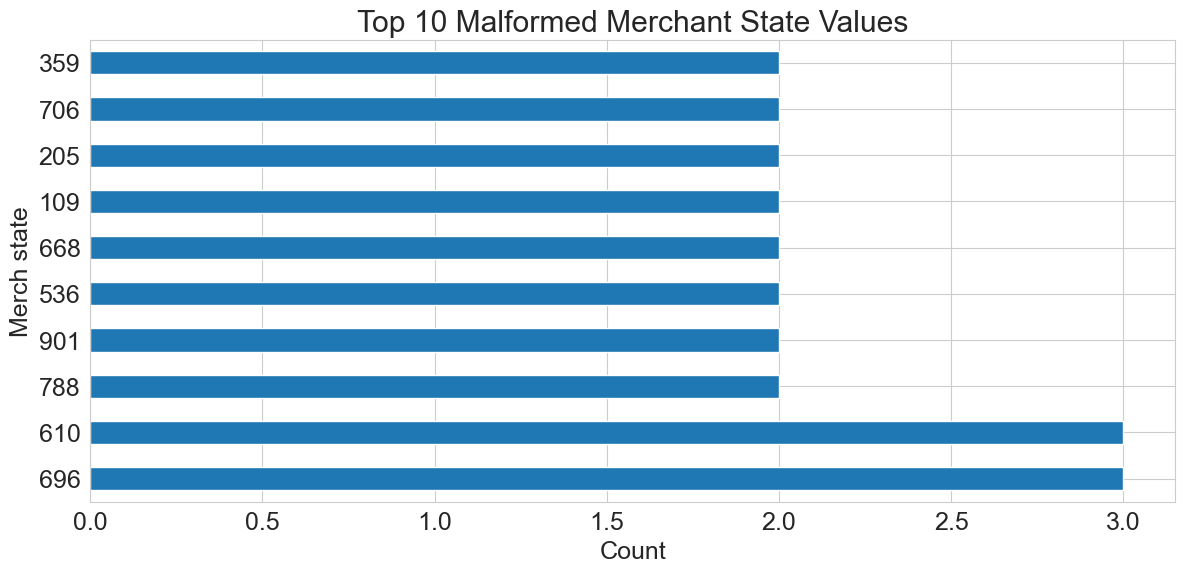

In [190]:
weird_states['Merch state'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 Malformed Merchant State Values")
plt.xlabel("Count")


Series([], Name: count, dtype: int64)

In [198]:
max_row = df.loc[[df['Amount'].idxmax()]]  # double brackets → keep it as DataFrame
max_row = max_row[['Recnum', 'Date', 'Merch description', 'Merchnum', 
                   'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud']]
max_row['Amount'] = max_row['Amount'].map('${:,.2f}'.format)
max_row



,Recnum,Date,Merch description,Merchnum,Merch state,Merch zip,Transtype,Amount,Fraud
53491,53492,2010-07-13,INTERMEXICO,NaN,NaN,NaN,P,"$3,102,045.53",0


In [199]:
max_row.to_csv("max_transaction_summary.csv", index=False)


In [200]:
high_amount = df[df['Amount'] > 5000]
fraud_rate_high = high_amount['Fraud'].mean()
overall_rate = df['Fraud'].mean()
print(f"Fraud rate overall: {overall_rate:.2%}")
print(f"Fraud rate for Amount > $5,000: {fraud_rate_high:.2%}")


Fraud rate overall: 2.53%
Fraud rate for Amount > $5,000: 40.45%


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Fraud_Rate_Comparison_High_Amount.png'

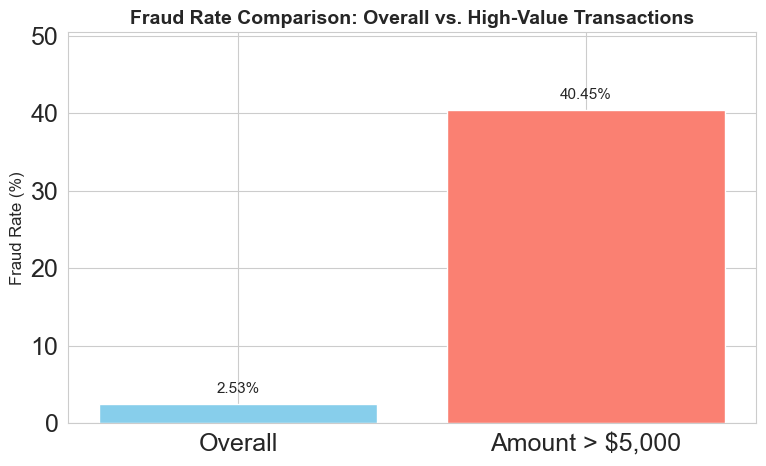

In [202]:
# Re-run after reset to generate the fraud rate comparison plot again

import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
file_path = "card transactions_2025.csv"
df = pd.read_csv(file_path)

# Calculate fraud rates
overall_rate = df['Fraud'].mean()
high_amount_rate = df[df['Amount'] > 5000]['Fraud'].mean()

# Prepare data
labels = ['Overall', 'Amount > $5,000']
rates = [overall_rate * 100, high_amount_rate * 100]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, rates, color=['skyblue', 'salmon'])

# Annotate percentages on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=11)

plt.title("Fraud Rate Comparison: Overall vs. High-Value Transactions", fontsize=14, fontweight='bold')
plt.ylabel("Fraud Rate (%)", fontsize=12)
plt.ylim(0, max(rates) + 10)
plt.tight_layout()

# Save figure
output_path = "/mnt/data/Fraud_Rate_Comparison_High_Amount.png"
plt.savefig(output_path)
plt.close()

output_path


In [203]:
df['Date'] = pd.to_datetime(df['Date'])
feb28 = df[df['Date'] == '2010-02-28']
len(feb28)


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/2633463215.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


691

In [204]:
len(feb28) / len(df) * 100


0.7022857317085565

In [205]:
feb28['Merch description'].value_counts().head(10)


Merch description
FEDEX SHP 02/23/10 AB#    23
FEDEX SHP 02/24/10 AB#    16
FEDEX SHP 02/22/10 AB#    16
SIGMA-ALDRICH             14
STAPLES #941               9
GLOBAL COMPUTER SUPPLY     8
CDW*GOVERNMENT INC         7
OFFICE DEPOT #1082         6
GSA/CUST SUPPLY CTR 96     6
PHENOMENEX INC             6
Name: count, dtype: int64

In [206]:
feb28['Fraud'].value_counts(normalize=True)


Fraud
0    0.98987
1    0.01013
Name: proportion, dtype: float64

In [208]:
df['Day'] = df['Date'].dt.date
daily_counts = df.groupby('Day').size().sort_values(ascending=False).head(10)
daily_counts


Day
2010-02-28    691
2010-08-10    610
2010-03-15    594
2010-09-13    594
2010-09-21    544
2010-09-07    542
2010-08-09    536
2010-08-31    534
2010-09-14    533
2010-08-01    521
dtype: int64

In [209]:
df['DayOfWeek'] = df['Date'].dt.day_name()
top_dates = ['2010-02-28', '2010-08-10', '2010-03-15', '2010-09-13', '2010-09-21','2010-09-07','2010-08-09','2010-08-31','2010-09-14','2010-08-01']  # fill with top 10
df[df['Date'].dt.date.astype(str).isin(top_dates)]['DayOfWeek'].value_counts()


TypeError: data type 'Average of the Dependent Variable: Fraud' not understood

In [210]:
import datetime

# Convert top date strings to actual datetime.date objects
top_dates = [
    datetime.date(2010, 2, 28),
    datetime.date(2010, 8, 10),
    datetime.date(2010, 3, 15),
    datetime.date(2010, 9, 13),
    datetime.date(2010, 9, 21),
    datetime.date(2010, 9, 7),
    datetime.date(2010, 8, 9),
    datetime.date(2010, 8, 31),
    datetime.date(2010, 9, 14),
    datetime.date(2010, 8, 1),
]

# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract day for matching
df['Day'] = df['Date'].dt.date

# Get value counts of day of week for those top dates
df[df['Day'].isin(top_dates)]['Date'].dt.day_name().value_counts()


Date
Tuesday    2763
Monday     1724
Sunday     1212
Name: count, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Transaction_Volume_By_Weekday_TopDates.png'

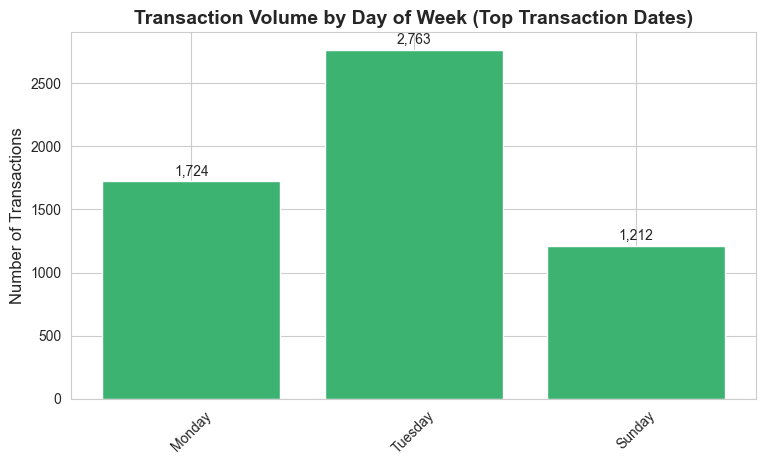

In [211]:
# Re-convert 'Date' column to datetime (required after reset)
df['Date'] = pd.to_datetime(df['Date'])

# Recreate 'Day' column as datetime.date
df['Day'] = df['Date'].dt.date

# Define the top transaction dates
import datetime
top_dates = [
    datetime.date(2010, 2, 28),
    datetime.date(2010, 8, 10),
    datetime.date(2010, 3, 15),
    datetime.date(2010, 9, 13),
    datetime.date(2010, 9, 21),
    datetime.date(2010, 9, 7),
    datetime.date(2010, 8, 9),
    datetime.date(2010, 8, 31),
    datetime.date(2010, 9, 14),
    datetime.date(2010, 8, 1),
]

# Calculate day-of-week counts for top dates
top_day_counts = df[df['Day'].isin(top_dates)]['Date'].dt.day_name().value_counts()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
top_day_counts = top_day_counts.reindex(weekday_order).dropna()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(top_day_counts.index, top_day_counts.values, color='mediumseagreen')

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20, f"{int(height):,}",
             ha='center', va='bottom', fontsize=10)

plt.title("Transaction Volume by Day of Week (Top Transaction Dates)", fontsize=14, fontweight='bold')
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save
output_path = "/mnt/data/Transaction_Volume_By_Weekday_TopDates.png"
plt.savefig(output_path)
plt.close()

output_path


In [212]:
# Check the unique time components in the Date field
df['Time'] = df['Date'].dt.time

# Count how many unique times there are
unique_times = df['Time'].nunique()

# Get the top 5 most common times
top_times = df['Time'].value_counts().head(5)

unique_times, top_times


(1,
 Time
 00:00:00    98393
 Name: count, dtype: int64)

In [214]:
df['Merch zip'].dtype


dtype('float64')

In [217]:
del str


In [218]:
# Drop nulls, convert safely to string, and count character lengths
df['Merch zip'].dropna().apply(lambda x: len(str(int(x)))).value_counts()


Merch zip
5    85408
4     8129
1       80
3       46
2        1
Name: count, dtype: int64

In [219]:
df[df['Merch zip'].dropna().apply(lambda x: len(str(int(x))) != 5)]['Merch zip'].value_counts()


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/1156673680.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Merch zip'].dropna().apply(lambda x: len(str(int(x))) != 5)]['Merch zip'].value_counts()


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/3446583374.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values, palette="Blues_d")


<Figure size 1200x600 with 0 Axes>

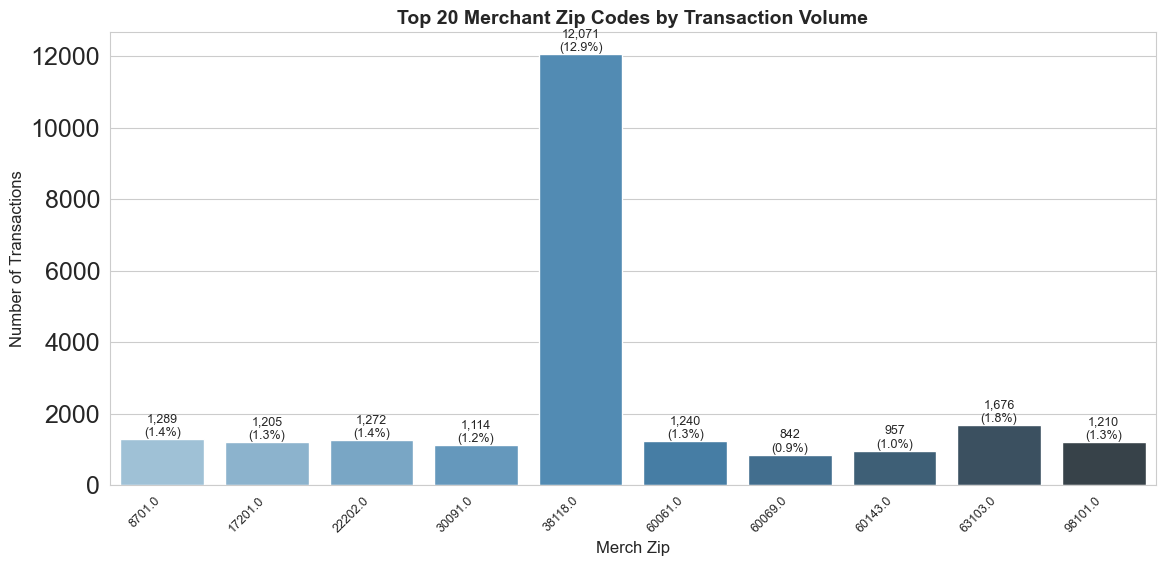

In [228]:
plt.figure(figsize=(12, 6))
top_20_zips = df['Merch zip'].value_counts().head(10).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values, palette="Blues_d")


# Rotate X-axis labels
plt.xticks(rotation=45, ha='right', fontsize=9)

# Annotate with count and percentage
total = df['Merch zip'].count()
for p in ax.patches:
    value = int(p.get_height())
    pct = value / total * 100
    ax.annotate(f"{value:,}\n({pct:.1f}%)",
                (p.get_x() + p.get_width()/2., value),
                ha='center', va='bottom', fontsize=9)

# Title and y-axis labels
plt.title("Top 20 Merchant Zip Codes by Transaction Volume", fontsize=14, fontweight='bold')
plt.xlabel("Merch Zip", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)

plt.tight_layout()


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/4125066578.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values, palette="Blues_d")


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Merch_Zip_Top_20_Sorted.png'

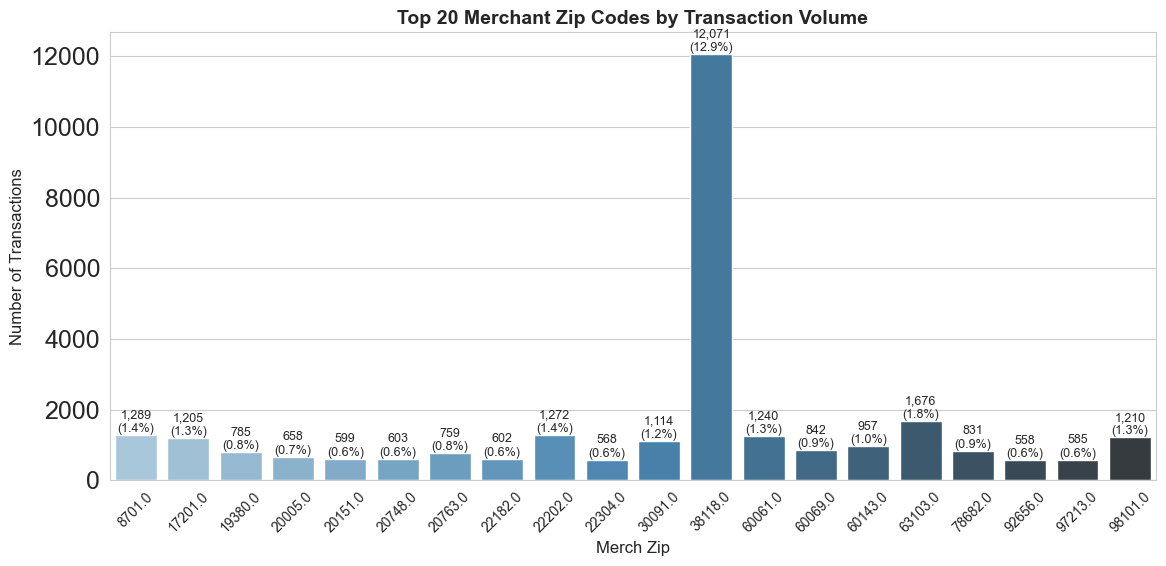

In [ ]:
# Sort the top 20 zips by transaction volume in descending order
top_20_zips = df['Merch zip'].value_counts().head(20).sort_values(ascending=False)

# Plot in descending order
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values, palette="Blues_d")

# Annotate with count and percentage
total = df['Merch zip'].count()
for p in ax.patches:
    value = int(p.get_height())
    pct = value / total * 100
    ax.annotate(f"{value:,}\n({pct:.1f}%)",
                (p.get_x() + p.get_width()/2., value),
                ha='center', va='bottom', fontsize=9)

# Title and labels
plt.title("Top 20 Merchant Zip Codes by Transaction Volume", fontsize=14, fontweight='bold')
plt.xlabel("Merch Zip", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Save
output_path = "/mnt/data/Merch_Zip_Top_20_Sorted.png"
plt.savefig(output_path)
plt.close()

output_path


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/1863972232.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values, palette="Blues_d", width=0.8)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Merch_Zip_Updated_Sorted_Aligned.png'

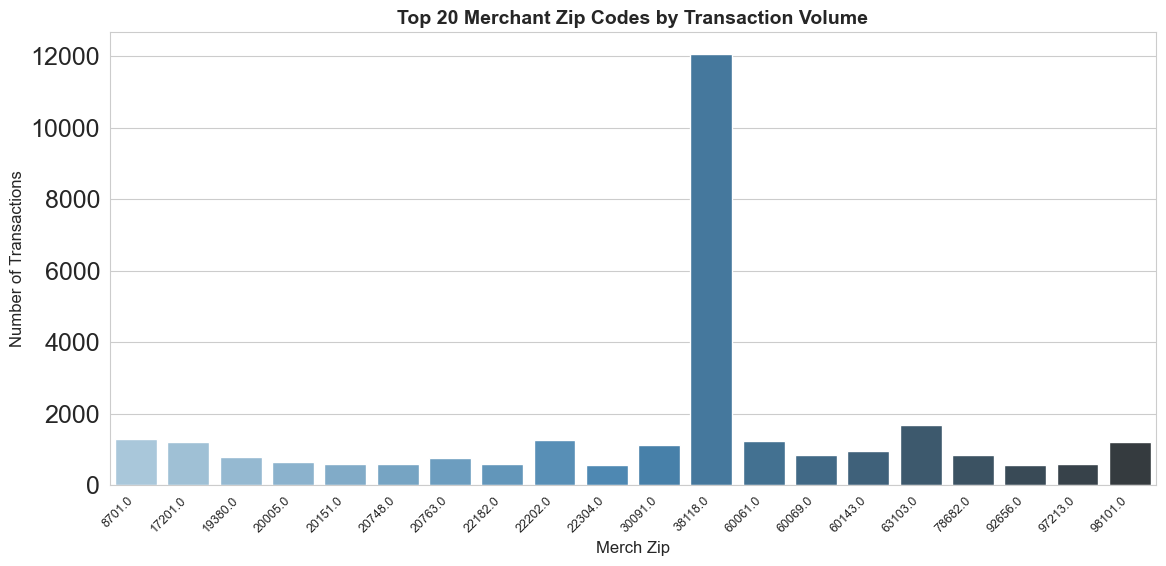

In [227]:
# Plot and Adjust Bar Width for better alignment
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values, palette="Blues_d", width=0.8)

# Rotate labels and adjust x-axis for alignment
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel("Merch Zip", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)

# Title
plt.title("Top 20 Merchant Zip Codes by Transaction Volume", fontsize=14, fontweight='bold')

# Tight layout
plt.tight_layout()

# Save the image
output_path = "/mnt/data/Merch_Zip_Updated_Sorted_Aligned.png"
plt.savefig(output_path)
plt.close()

output_path


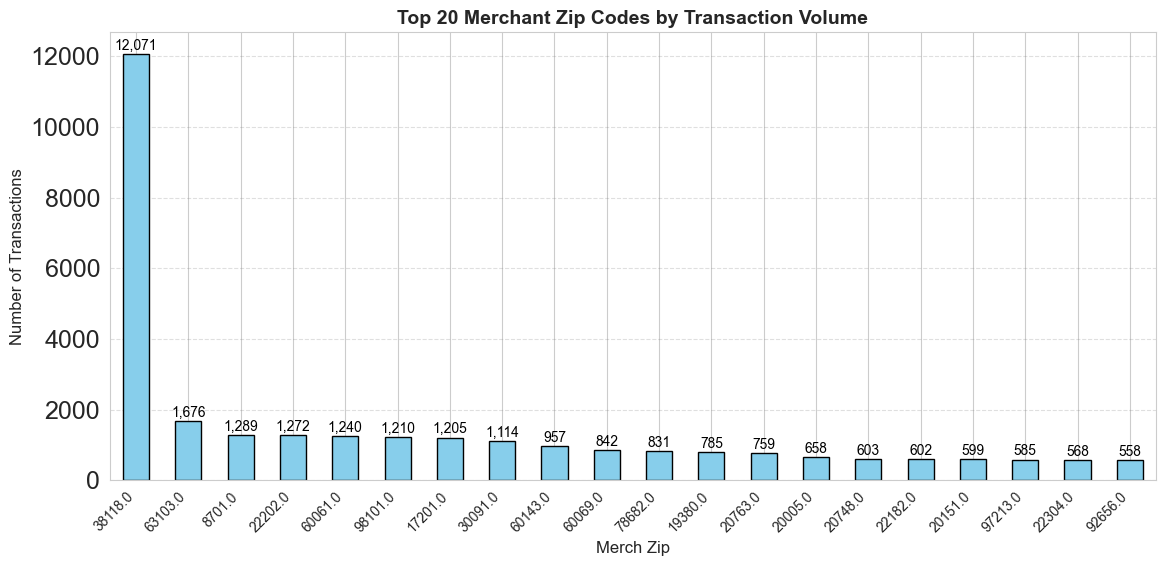

In [235]:
# Get top 20 counts for 'Merch zip'
counts = df['Merch zip'].value_counts().head(20)

# Plot bar chart
plt.figure(figsize=(12, 6))
ax = counts.plot(kind='bar', color='skyblue', edgecolor='black')
# ax = sns.barplot(x=top_20_zips.index, y=top_20_zips.values,  width=0.8)
# Rotate X-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Annotate counts on top of bars
for i, v in enumerate(counts):
    ax.text(i, v + counts.max() * 0.01, f'{v:,}', ha='center', color='black', fontsize=10)

# Set plot titles and labels
plt.title("Top 20 Merchant Zip Codes by Transaction Volume", fontsize=14, fontweight='bold')
plt.xlabel("Merch Zip", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)

# Add gridlines on y-axis
ax.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=0.25)

# Show the plot
plt.tight_layout()
plt.show()


In [240]:
# Convert Date column to datetime (in case it's not)
df['Date'] = pd.to_datetime(df['Date'])

# Create a date range from min to max date in the dataset
full_date_range = pd.date_range(start=df['Date'].min().date(), end=df['Date'].max().date())

# Extract only the date part (no time)
actual_transaction_dates = df['Date'].dt.date.unique()

# Find which dates in the full range are missing from the dataset
missing_dates = set(full_date_range.date) - set(actual_transaction_dates)

# Return number of missing dates and the first few
len(missing_dates), sorted(list(missing_dates))[:10]


/var/folders/3y/0sfsml2522b8xp4xn2f69tzm0000gn/T/ipykernel_65950/3202103239.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


(0, [])

In [241]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2010-12-31 00:00:00'))